In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from import_KK import *
# DeviceStrategy_CPU()
DeviceStrategy_GPU()
from module_KTX_KK import * 
from preprocessing_KK import *
from preprocessing_project_KK import *
from description_KK import *
from algorithm_machinelearning_KK import *
from algorithm_deeplearning_KK import *
from evaluation_KK import *
from visualization_KK import *


=========== GPU Strategy ===========
Detected GPUs:
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TF using MirroredStrategy with 2 GPUs:
 ['/GPU:0', '/GPU:1']


======= GPU / CUDA / STATUS ========
Cuda Ready?        True
CUDA Version:      12.5.1
cuDNN Version:     9

TF Version:        2.19.0
Keras Version:     3.10.0
True
Torch Version:       2.7.1+cu126
Torch CUDA Version:  12.6
Torch cuDNN Version: 90501

Torch GPUs Available: 2
Use the GPU: NVIDIA GeForce RTX 3090



In [3]:
def preprocess_data(df, excluded_columns, test_size, random_state):  
    # 수송인원 높은 역 필터링
    top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', 
                  '을지로입구', '종각', '가산디지털단지', '서울대입구', '성수', '혜화', '양재', 
                   '사당', '명동', '압구정', '수유', '연신내', '건대입구', '합정', '신사', '광화문', 
                    '시청', '여의도', '경복궁', '안국', '종로3가'] 
    
    #top_stations = ['서울대입구','선릉','성수','신림','신도림'] 
    
    df = df[df['역명'].isin(top_stations)].reset_index(drop=True)
    
    selected_columns = df.columns
    
    feature_columns = [col for col in selected_columns if col not in excluded_columns]
    
    # 학습용과 테스트용 데이터로 분할
    df_train, df_test = df[df['날짜'] <= '2022-12-31'], df[df['날짜'] > '2022-12-31']
    X_train, X_test = df_train[feature_columns], df_test[feature_columns]
    Y_train, Y_test = df_train['승강장_혼잡도'], df_test['승강장_혼잡도']
    # X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, random_state=random_state)
    
    # 스케일링
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.fit_transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # 결과를 딕셔너리 형태로 반환
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        # 'X_val': X_val,
        # 'Y_val': Y_val,
        'X_test': X_test,
        'Y_test': Y_test,
        'X_train_scaled': X_train_scaled,
        # 'X_val_scaled': X_val_scaled,
        'X_test_scaled': X_test_scaled,
        'feature_columns': feature_columns,
        'scaler': scaler,  # 추가
        'df_train': df.iloc[X_train.index],
        # 'df_val': df.iloc[X_val.index],
        'df_test': df.iloc[X_test.index]
    }
    
    return data, feature_columns

# Hyperparameters

In [4]:
# Data
FOLDER_GDM, FOLDER_GDS = get_google_drivelocation(gdrive='z', glocation=os.path.join('Research', 'SavedData', 'KoSubway'))
FOLDER_LOCATION = FOLDER_GDM
FILENAME = 'df_prep_20241112_SCI.csv'
FILE_LOCATION = os.path.join(FOLDER_LOCATION, FILENAME)

# Preprocessing
Y_colname = '승강장_혼잡도'
X_reverse = None
X_nullmax = None
X_nullmin = None
X_dummy = None
X_encoding = None
X_delYrelated = None
X_del = [
    '날짜', '호선', '역명', '승차인원', '하차인원', '승하차인원', '면적', '수송인원수', 
    '승강장혼잡도1', '승강장혼잡도2', '승하차인원차', '상선 혼잡도', '하선 혼잡도', 
    '요일구분', '일별_승하차인원_합', '시간대별_승하차_비율', '시간대별_환승_승객_수', 
    'λ_승차', 'λ_환승', 'λ_total', 'W_승차', 'W_환승', 'W_total', 'L_total', '승강장_혼잡도'
]
X_colbasic = [
    '시간', '우대권인원수', '청소년인원수', '출입구', '섬식여부', '환승노선_개수', '환승유입인원수',
    '요일_Saturday', '요일_Sunday', '공휴일여부', '요일_Monday', '요일_Tuesday', '요일_Wednesday', '요일_Thursday', '요일_Friday',
    '년도_2021', '년도_2022', '년도_2023', '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10',
    '월_11', '월_12', '일_1', '일_2', '일_3', '일_4', '일_5', '일_6', '일_7', '일_8', '일_9', '일_10', '일_11', '일_12',
    '일_13', '일_14', '일_15', '일_16', '일_17', '일_18', '일_19', '일_20', '일_21', '일_22', '일_23', '일_24', '일_25',
    '일_26', '일_27', '일_28', '일_29', '일_30', '일_31', '상행_평균운행간격', '하행_평균운행간격', '상행_운행횟수', '하행_운행횟수',
    '역_시간별_평균운행간격', '월_카운트', '월평균_환승유입인원수'
]
X_colweather = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '적설(cm)']
X_colecon = [
    '지하철요금', '달러 환율', '보통휘발유', '자동차용경유', '실업률(%)', '청년실업률(%)',
    '동행지수 순환변동치', '선행지수 순환변동치', '서울_인구(천명)', '서울_인구밀도', '수도권_인구(천명)', '수도권_인구밀도',
    '자동차등록대수(만대)', '기준금리', '한국CPI', 'CPI_대비_지하철요금'
]

TEST_SIZE = 0.2
RANDOM_STATE = 123
CLASS_STAT = False
## 'RandomUnderSampler' <<< 'TomekLinks' << 'CondensedNearestNeighbour' < 'OneSidedSelection'
## 'SMOTE' <<< 'SMOTETomek' << 'BorderlineSMOTE' < 'ADASYN', 'auto'
SAMPLING_METHOD = 'auto'
## 'minority', 'not majority', 'not minority', 'all', 'auto'
SAMPLING_STRATEGY = 'auto'    # 'minority', 'not majority', 'not minority', 'all', 'auto'
SCALER = 'minmax'
LABEL_LIST = None

# Model
## Common
TUNE_TRIALS = 10
CV_SPLITS = 5
## ML
TUNE_METRIC = 'RMSE' # Default('auto'): 'F1-score', 'RMSE' - 접두사 없어도 자동으로 validation set 기준으로 판단TUNE_METRIC = 'auto'
## DL
tf.random.set_seed(123)
NODE_MLP = [128, 256, 128, 64, 32, 10]
NODE_CNN = [32, 64, 128]
VALIDATION_SPLIT = 0.2
if VALIDATION_SPLIT != None:
    VALIDATION_DATA = None
BATCH_SIZE = 64
EPOCHS = 1000
VERBOSE = 0
TUNE_METRIC_DL = 'val_RMSE'
## Final + XAI
METRIC_FINAL = "RMSE"
SHAP = True
INTERACTION = True
INTERACTION_SAMPLES = 2000
# FEATURE_PERTURBATION = 'tree_path_dependent'    # 'tree_path_dependent', 'interventional'
X_TOP_DISPLAY = 50

# Save
SAVE_NAME_PREDSTATTR = 'DescriptiveStatistics_BinaryPredTrain.csv'
SAVE_NAME_PREDSTATTE = 'DescriptiveStatistics_BinaryPredTest.csv'
SAVE_NAME_ML = 'Performance_ML'
SAVE_NAME_DL = 'Performance_DL'
SAVE_NAME_PERFORMANCE = 'Performance.csv'

# Data Preprocessing

In [5]:
# 데이터로딩
df = pd.read_csv(FILE_LOCATION, encoding='utf-8-sig')
display(df.shape)

(1649016, 114)

In [6]:
# 전처리
df_prep, X_colname = preprocess_data(df, X_del, TEST_SIZE, RANDOM_STATE)
display(df_prep['X_train'].shape, df_prep['X_test'].shape)
X_train = df_prep['X_train'].copy()
X_test = df_prep['X_test'].copy()
Y_train = df_prep['Y_train'].copy()
Y_test = df_prep['Y_test'].copy()
# Sampling
X_train = X_train.sample(int(X_test.shape[0]))
Y_train = Y_train.loc[X_train.index]
display(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1080844, 89)

(568172, 89)

(568172, 89)

(568172, 89)

(568172,)

(568172,)

# Modeling

## Machine Learning

In [7]:
# # Setting
# algorithm_list = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
# TUNE_TRIALS = None
# # TUNE_TRIALS = 10

# # ML 실행
# results_ML, scores_ML = modeling_ML(
#     algos=algorithm_list,
#     X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
#     X_colname=X_colname,
#     params=None, # 특정 알고리즘
#     tune_trials=TUNE_TRIALS, # 최적화 여부
#     cv_splits=CV_SPLITS,
#     tune_metric=TUNE_METRIC,
#     shap=not SHAP, 
#     X_selected=None, # shap에서만 작동
#     interaction=not INTERACTION,
#     interaction_samples=INTERACTION_SAMPLES, 
#     X_top_display=X_TOP_DISPLAY, 
#     label_list=LABEL_LIST,
# )

▶ Detected Task Type: [ Regression ] (Target: continuous)

   Running Machine Learning Algorithm: Linear Regression (Regression)
Learning...:  2026-01-21 00:50:04.328053


  0%|          | 0/10 [00:00<?, ?it/s]

[Linear Regression] Best Optuna Score (RMSE):  -0.007296216985696697
[Linear Regression] Best Tuning Parameters:  {'fit_intercept': True, 'n_jobs': -1}

Explanations...:  2026-01-21 00:51:10.052123
Explanations of Y:


Features       Coef      Features        Coef
0      상행_평균운행간격 1,016.3611  역_시간별_평균운행간격 -2,032.7198
1      하행_평균운행간격 1,016.3602           일_4     -8.7996
2            월_1    28.6312           일_6     -8.7996
3            월_3    28.6309           일_5     -8.7995
4            월_8    28.6309           일_1     -8.7995
5           월_10    28.6308           일_2     -8.7995
6            월_5    28.6306          일_14     -8.7994
7            월_7    28.6306          일_12     -8.7994
8           월_12    28.6304           일_7     -8.7994
9            월_6    26.6453          일_10     -8.7994
10           월_9    26.6452          일_30     -8.7994
11          월_11    26.6451          일_31     -8.7994
12           월_4    26.6451          일_13     -8.7994
13     요일_Friday    23.2090           일_9     -8.7994
14   요일_Thursday    23.2090          일_16     -8.7994
15    요일_Tuesday    23.2089           일_3     -8.7993
16  요일_Wednesday    23.2088          일_21     -8.7993
17     요일_Monday    23.2084          일_23     -8.7993
18   요일_Saturday    23.2076          일_29     -8.7993
19     요일_Sunday    23.2056           일_8     -8.7992
20           월_2    22.6734          일_11     -8.7992
21       년도_2021     0.7914          일_28     -8.7992
22       년도_2022     0.7909          일_20     -8.7992
23       년도_2023     0.0018          일_18     -8.7992
24       상행_운행횟수     0.0007          일_17     -8.7992
25           출입구     0.0005          일_15     -8.7991
26       하행_운행횟수     0.0002          일_19     -8.7991
27            시간     0.0001          일_22     -8.7991
28        청소년인원수     0.0000          일_27     -8.7991
29        우대권인원수     0.0000          일_25     -8.7991
30   월평균_환승유입인원수     0.0000          일_24     -8.7990
31           NaN        NaN          일_26     -8.7990
32           NaN        NaN         월_카운트     -1.9856
33           NaN        NaN         공휴일여부     -0.0029
34           NaN        NaN          섬식여부     -0.0013
35           NaN        NaN       환승노선_개수     -0.0011
36           NaN        NaN       환승유입인원수     -0.0000

Performance Evaluations...:  2026-01-21 00:51:10.062665
Performance: 
   [Info] Linear Regression (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


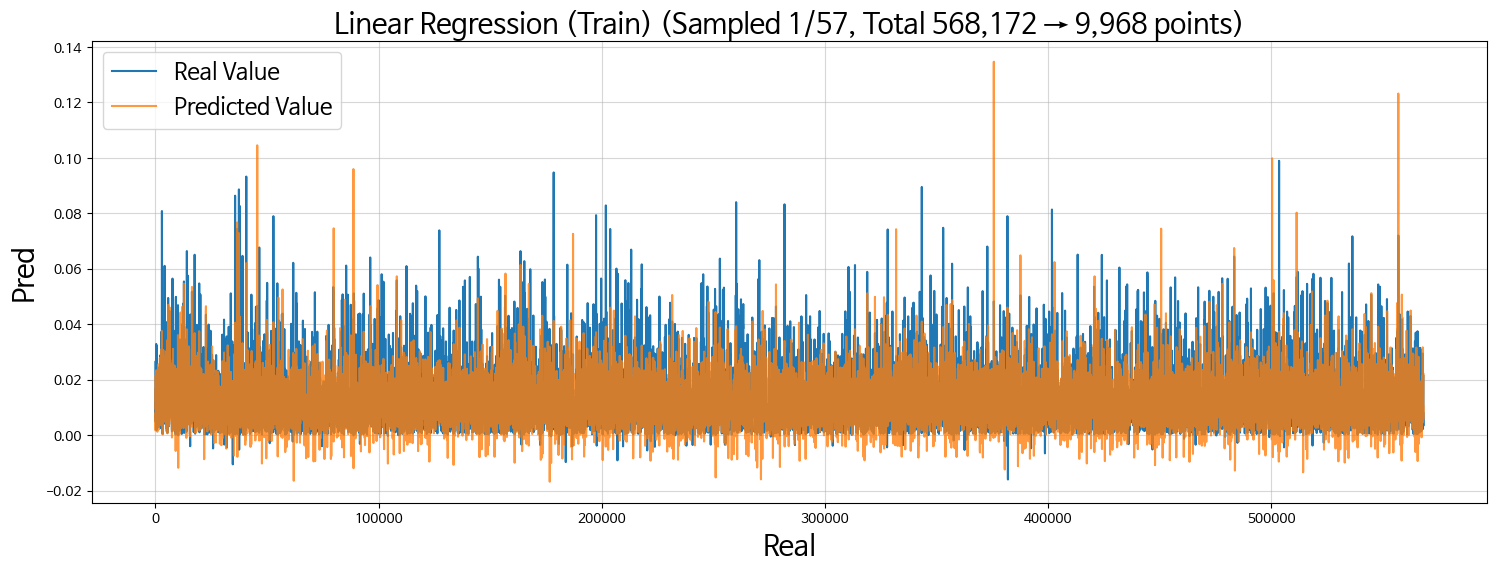

   [Info] Linear Regression (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


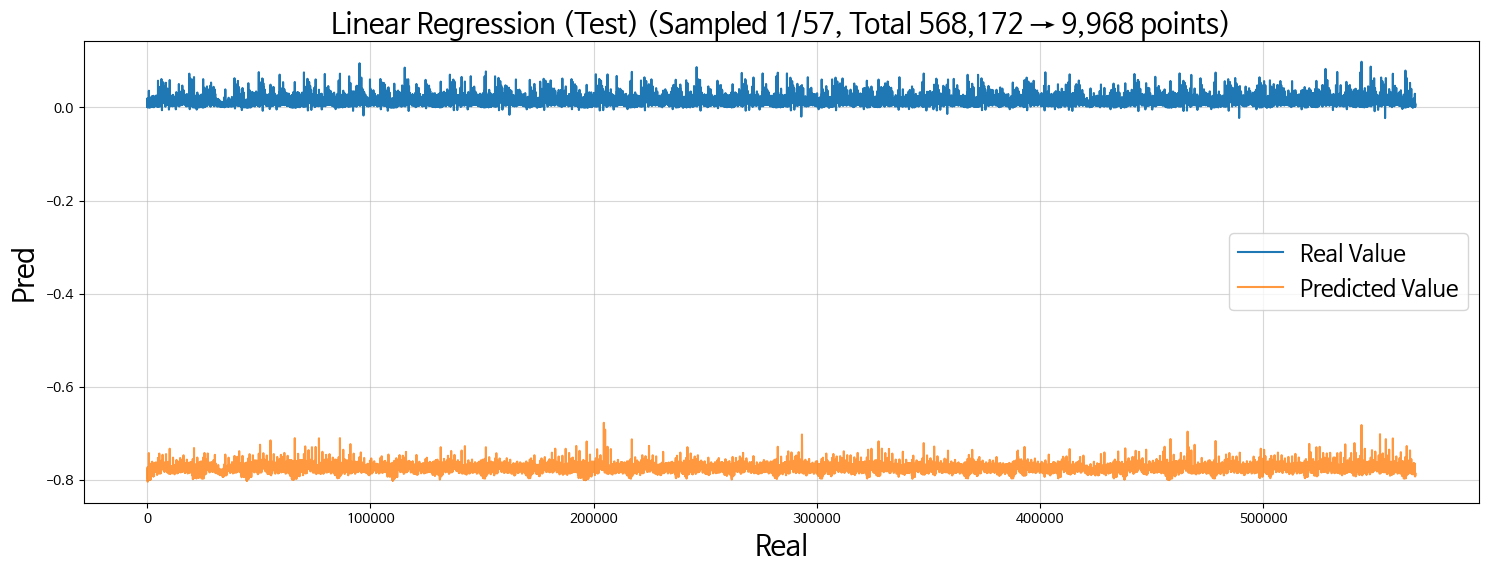

Algorithm            Dataset   RMSE            MSPE    MAE  \
0  Linear Regression          Train set 0.0073     37,564.5117 0.0050   
1  Linear Regression     Validation(CV) 0.0073     38,772.5216 0.0050   
2  Linear Regression           Test set 0.7888 66,196,662.2008 0.7888   
3  Linear Regression  Entire population 0.5578 33,117,113.3562 0.3969   

      MAPE  MedAE  MedAPE          R2  
0   5.0612 0.0036  0.3704      0.6082  
1   5.0617 0.0036  0.3704      0.6081  
2 348.2853 0.7882 73.4617 -3,870.4294  
3 176.6732 0.4201 13.9188 -2,085.9536

   [Save] Linear Regression Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_Linear Regression_20260121_005110.pkl
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_Linear Regression_20260121_005110.json

   Running Machine Learning Algorithm: Random Forest (Regression)
Learning...:  2026-01-21 00:51:10.998163


  0%|          | 0/10 [00:00<?, ?it/s]

[Random Forest] Best Optuna Score (RMSE):  -0.0009491728735318835
[Random Forest] Best Tuning Parameters:  {'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 123, 'n_jobs': -1}

Explanations...:  2026-01-21 02:04:34.407868
Explanations of Y:


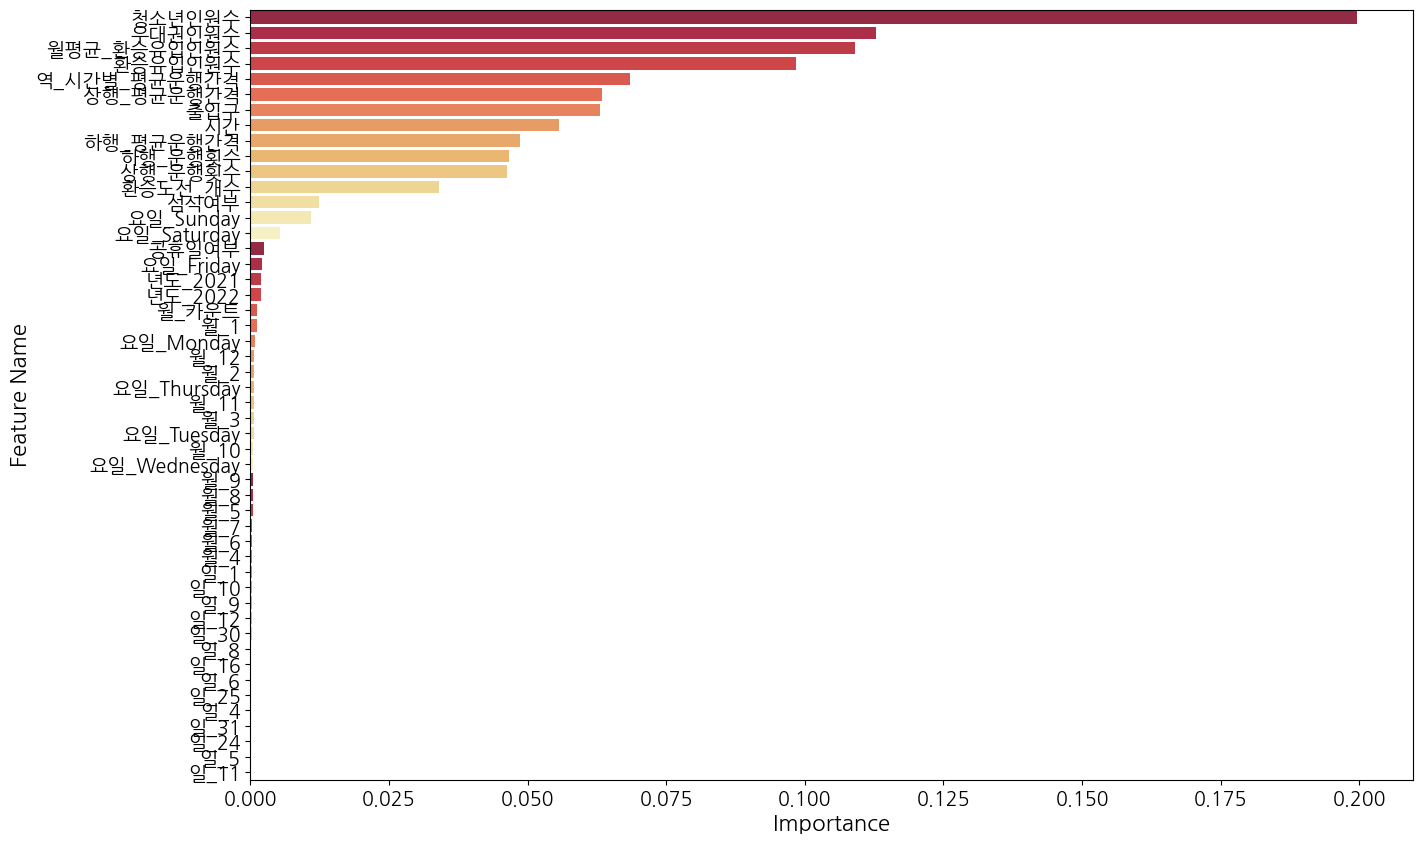

Performance Evaluations...:  2026-01-21 02:04:34.891315
Performance: 
   [Info] Random Forest (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


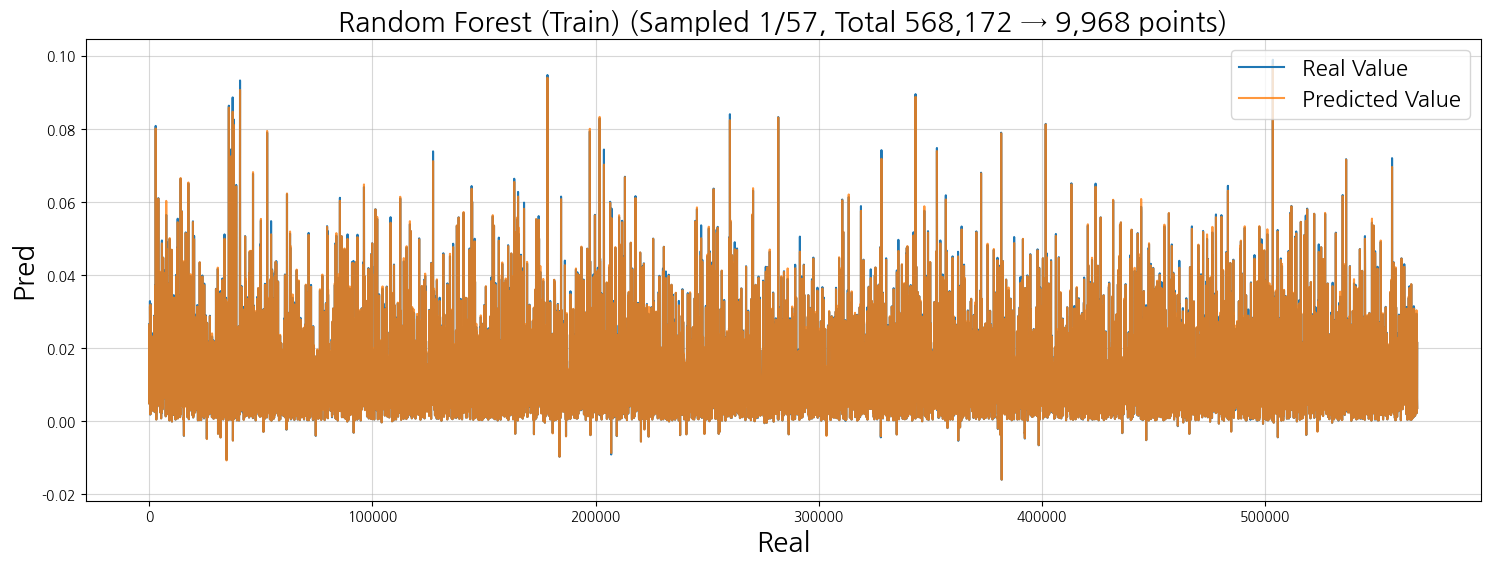

   [Info] Random Forest (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


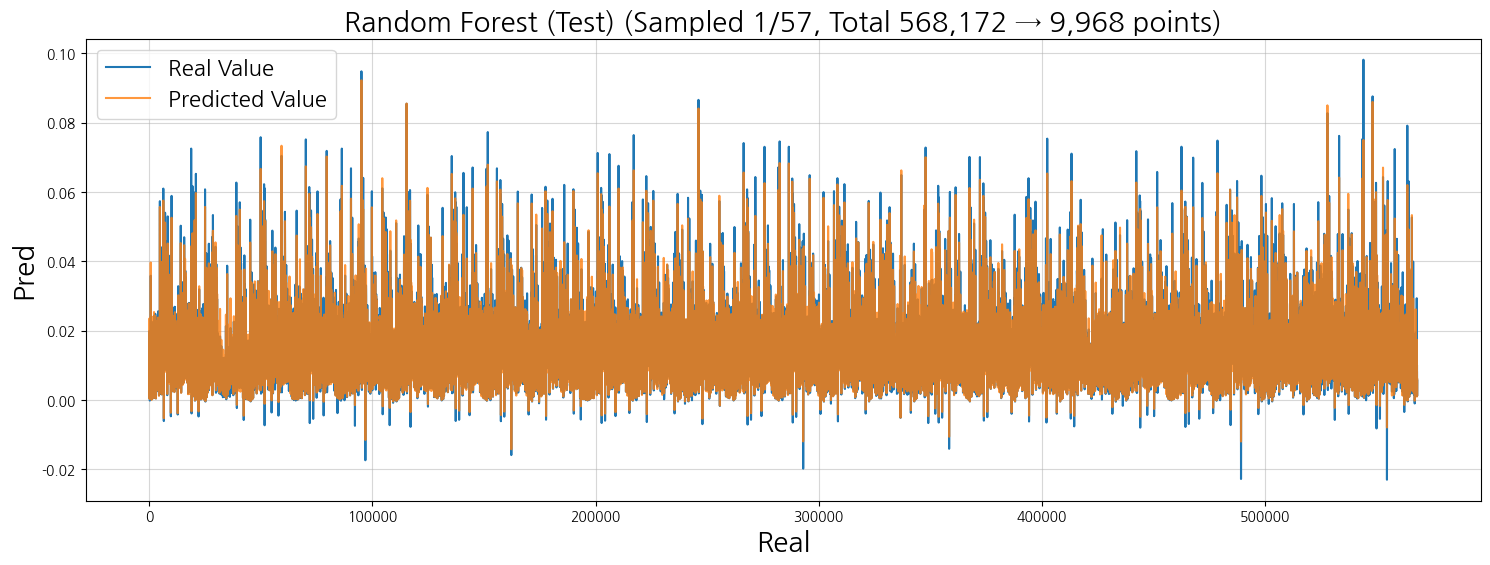

Algorithm            Dataset   RMSE   MSPE    MAE   MAPE  MedAE  \
0  Random Forest          Train set 0.0003 0.1944 0.0002 0.0224 0.0001   
1  Random Forest     Validation(CV) 0.0009 0.5778 0.0005 0.0606 0.0002   
2  Random Forest           Test set 0.0024 6.7784 0.0015 0.2207 0.0009   
3  Random Forest  Entire population 0.0017 3.4864 0.0008 0.1215 0.0003   

   MedAPE     R2  
0  0.0109 0.9992  
1  0.0259 0.9934  
2  0.0858 0.9641  
3  0.0281 0.9803

   [Save] Random Forest Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_Random Forest_20260121_020443.pkl
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_Random Forest_20260121_020443.json

   Running Machine Learning Algorithm: XGBoost (Regression)
Learning...:  2026-01-21 02:05:49.285189


  0%|          | 0/10 [00:00<?, ?it/s]

[XGBoost] Best Optuna Score (RMSE):  -0.007755693735664271
[XGBoost] Best Tuning Parameters:  {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.08310970327482575, 'subsample': 0.9809360823177646, 'colsample_bytree': 0.6525728640634835, 'min_child_weight': 6.941882324519403, 'gamma': 1.9779874294781141, 'reg_alpha': 0.015161588588605517, 'reg_lambda': 1.1812506989750982e-07, 'random_state': 123, 'n_jobs': -1, 'tree_method': 'hist', 'verbosity': 0}

Explanations...:  2026-01-21 02:07:00.748911
Explanations of Y:


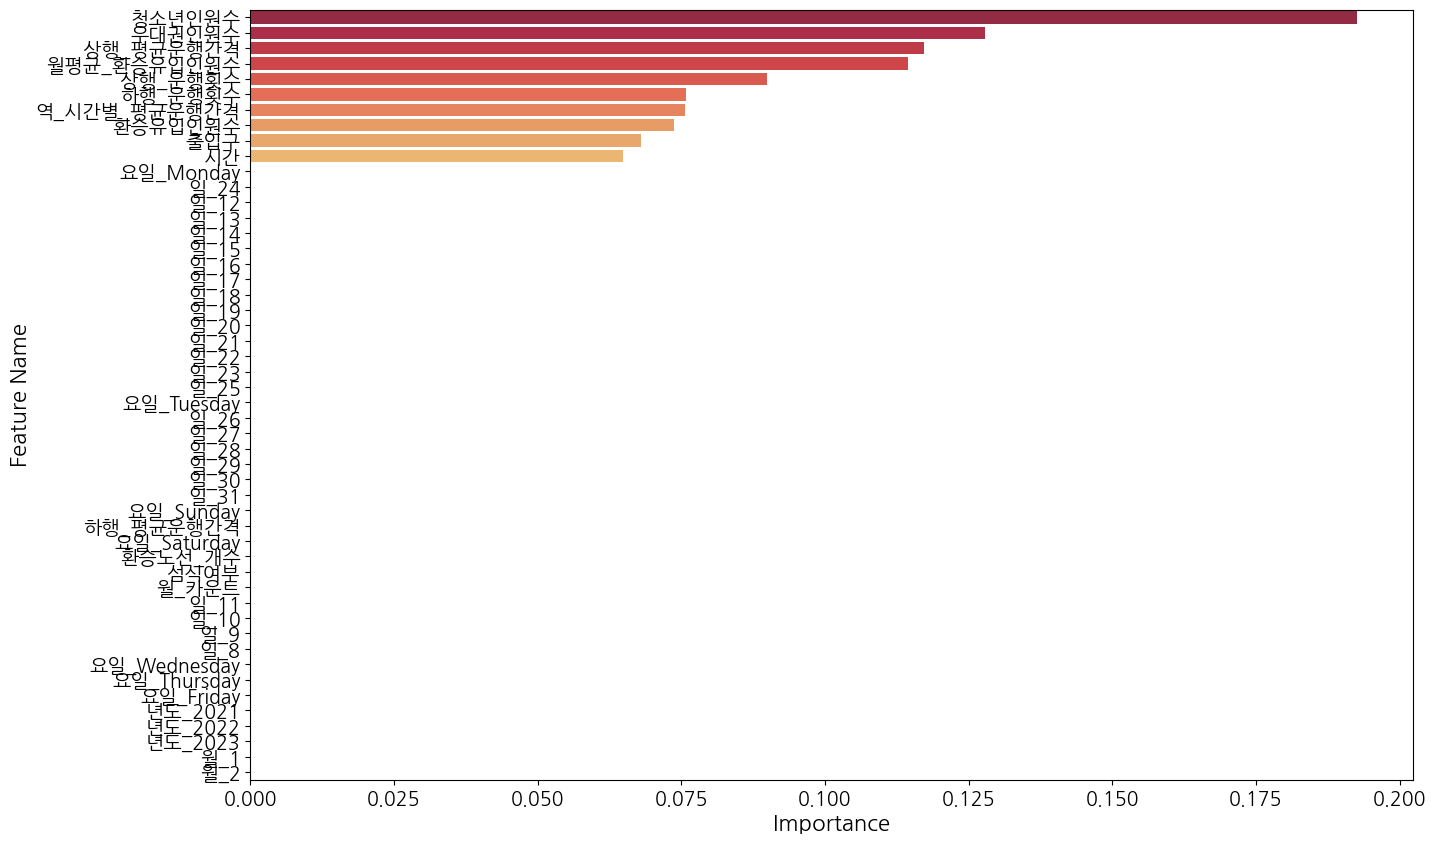

Performance Evaluations...:  2026-01-21 02:07:01.193264
Performance: 
   [Info] XGBoost (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


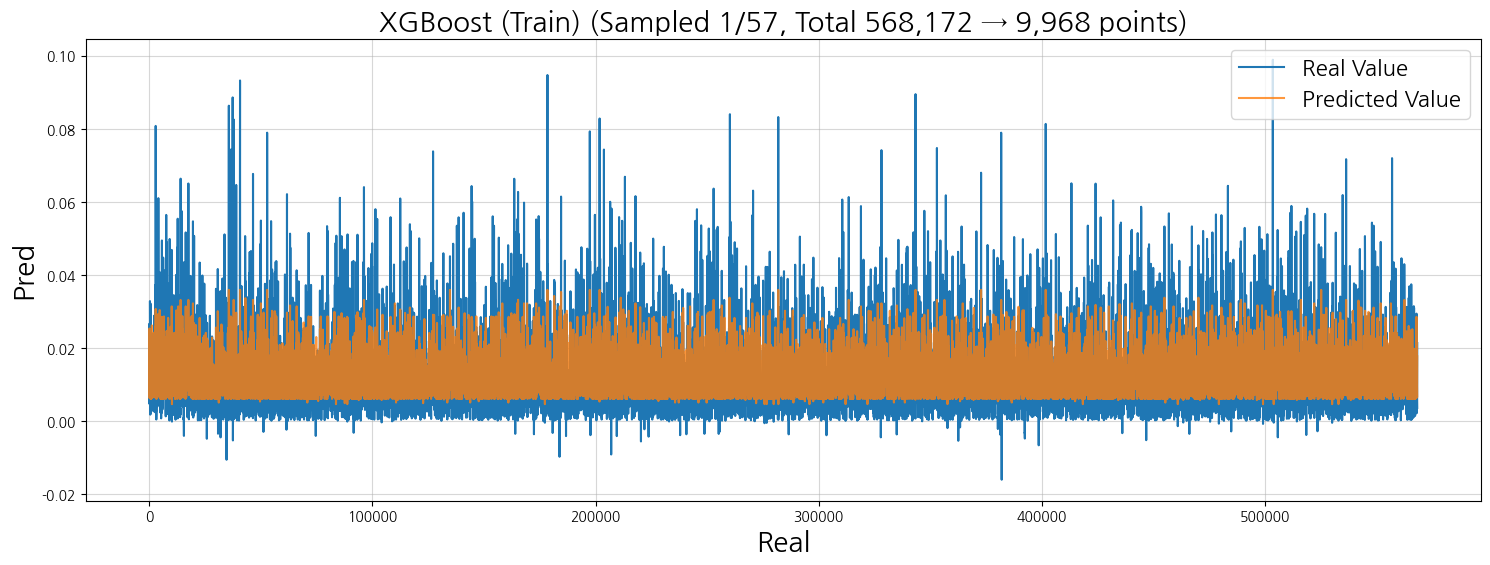

   [Info] XGBoost (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


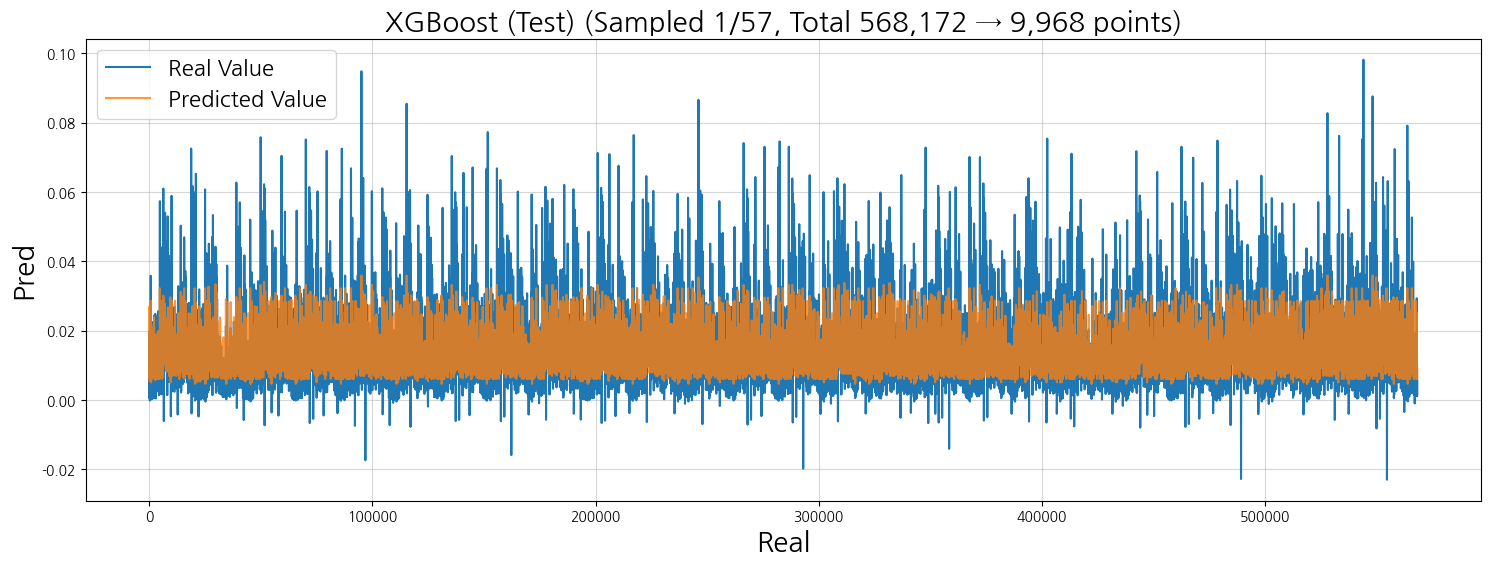

Algorithm            Dataset   RMSE        MSPE    MAE   MAPE  MedAE  \
0   XGBoost          Train set 0.0075 17,218.9532 0.0053 3.2385 0.0041   
1   XGBoost     Validation(CV) 0.0078 13,989.9894 0.0055 3.4419 0.0042   
2   XGBoost           Test set 0.0088  4,223.2590 0.0061 2.7343 0.0045   
3   XGBoost  Entire population 0.0082 10,721.1061 0.0057 2.9864 0.0043   

   MedAPE     R2  
0  0.4191 0.5828  
1  0.4311 0.5571  
2  0.3877 0.5209  
3  0.4030 0.5518

   [Save] XGBoost Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_XGBoost_20260121_020702.pkl
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_XGBoost_20260121_020702.json

   Running Machine Learning Algorithm: LightGBM (Regression)
Learning...:  2026-01-21 02:07:02.111225


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] Best Optuna Score (RMSE):  -0.003881130210819257
[LightGBM] Best Tuning Parameters:  {'n_estimators': 1000, 'learning_rate': 0.09504322670667681, 'num_leaves': 74, 'max_depth': 25, 'min_child_samples': 12, 'subsample': 0.5034990804236449, 'colsample_bytree': 0.9209047946711404, 'min_split_gain': 0.04266765796281491, 'extra_trees': False, 'reg_alpha': 0.015813396459590248, 'reg_lambda': 1.9244672832099237, 'random_state': 123, 'n_jobs': -1, 'verbose': -1}

Explanations...:  2026-01-21 02:07:56.220281
Explanations of Y:


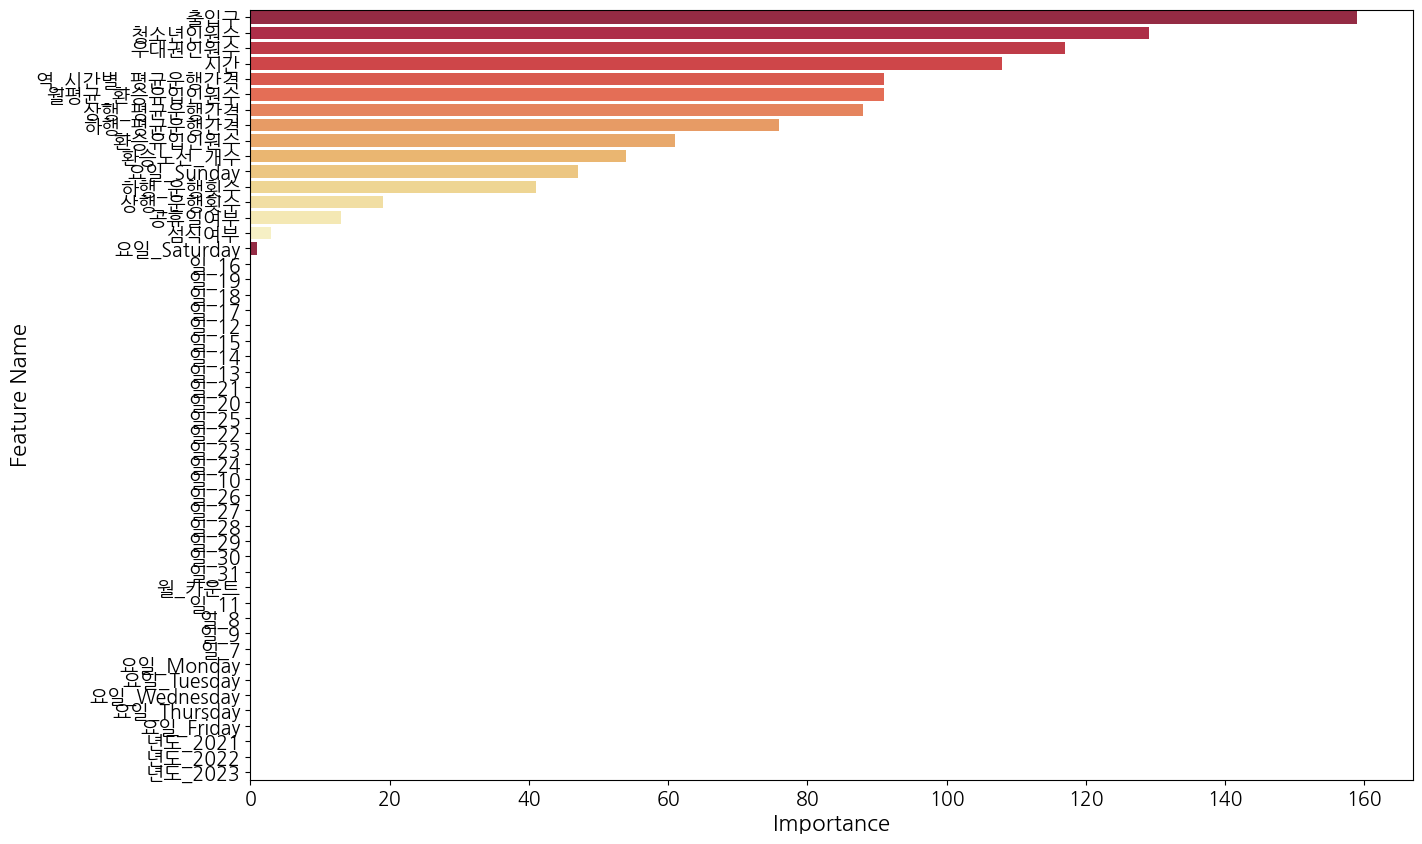

Performance Evaluations...:  2026-01-21 02:07:56.651425
Performance: 
   [Info] LightGBM (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


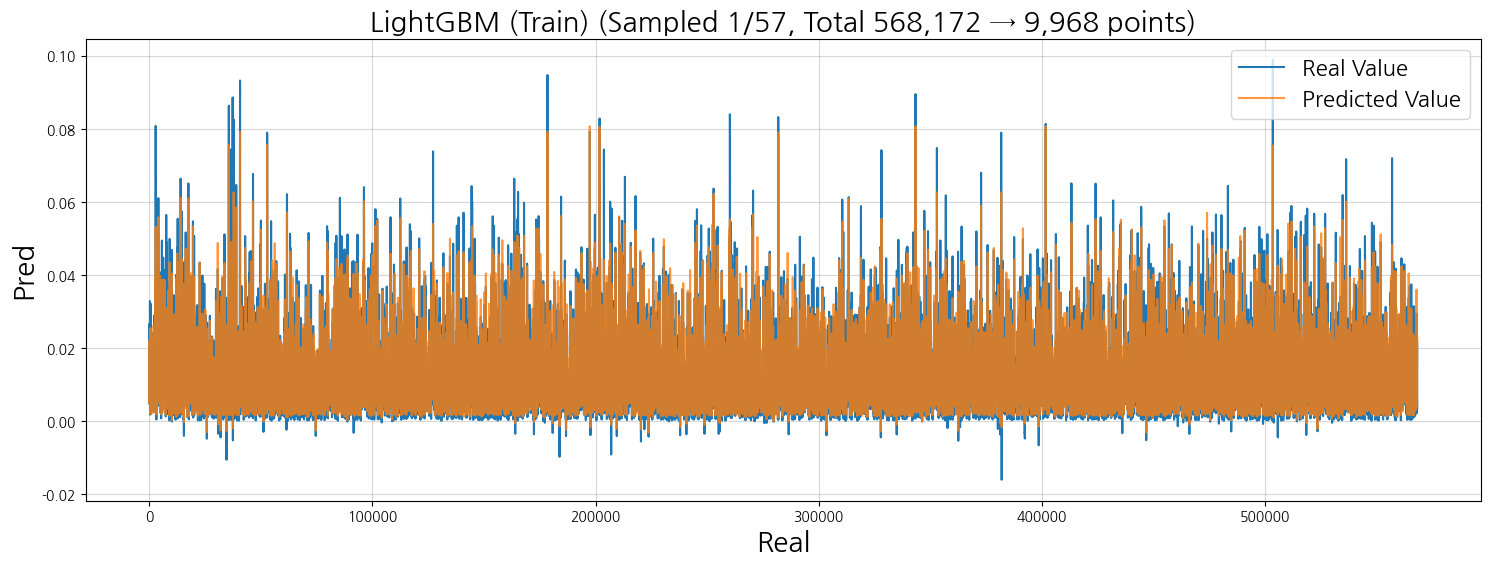

   [Info] LightGBM (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


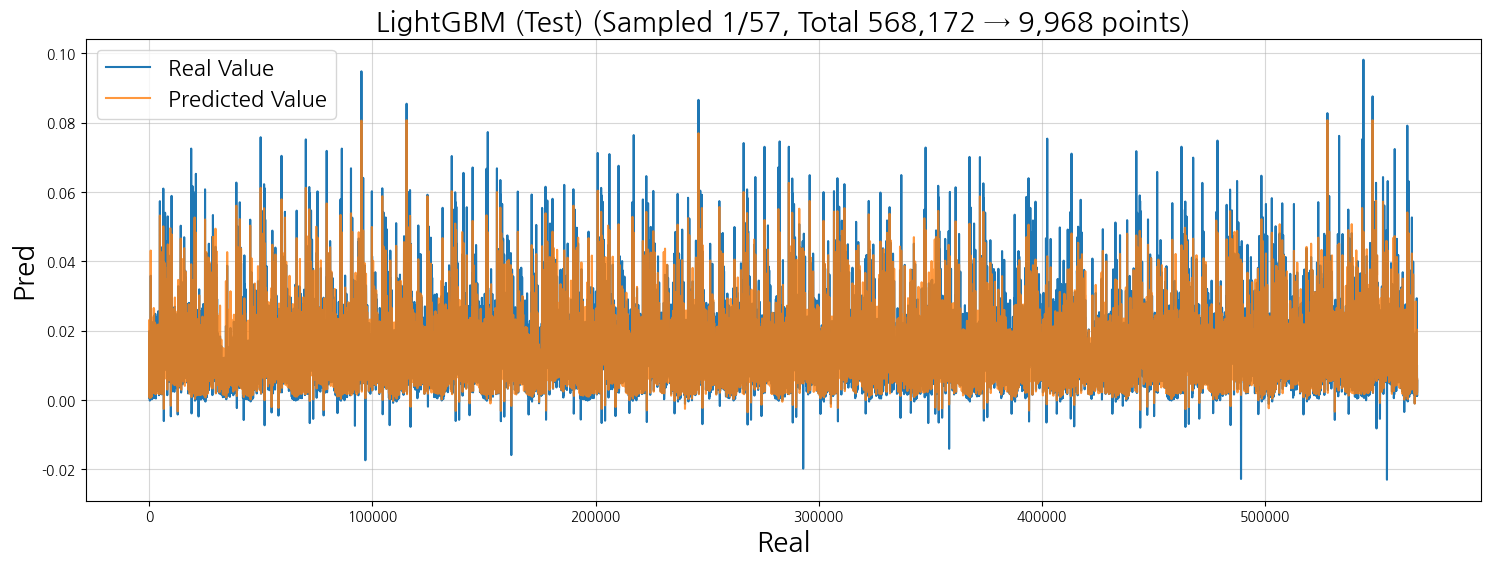

Algorithm            Dataset   RMSE     MSPE    MAE   MAPE  MedAE  MedAPE  \
0  LightGBM          Train set 0.0037 664.0568 0.0026 0.8204 0.0017  0.2077   
1  LightGBM     Validation(CV) 0.0039 485.2118 0.0027 0.8526 0.0018  0.2134   
2  LightGBM           Test set 0.0048 307.9518 0.0032 0.7952 0.0021  0.2126   
3  LightGBM  Entire population 0.0043 486.0043 0.0029 0.8078 0.0019  0.2102   

      R2  
0 0.8965  
1 0.8891  
2 0.8586  
3 0.8766

   [Save] LightGBM Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_LightGBM_20260121_020757.pkl
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_LightGBM_20260121_020757.json

   Running Machine Learning Algorithm: CatBoost (Regression)
Learning...:  2026-01-21 02:07:57.676928


  0%|          | 0/10 [00:00<?, ?it/s]

[CatBoost] Best Optuna Score (RMSE):  -0.0007724046093741783
[CatBoost] Best Tuning Parameters:  {'iterations': 950, 'depth': 10, 'learning_rate': 0.14539325480083018, 'l2_leaf_reg': 1.1487381919895239, 'subsample': 0.8258868116680695, 'grow_policy': 'Depthwise', 'random_state': 123, 'verbose': 0, 'allow_writing_files': False}

Explanations...:  2026-01-21 02:18:54.497442
Explanations of Y:


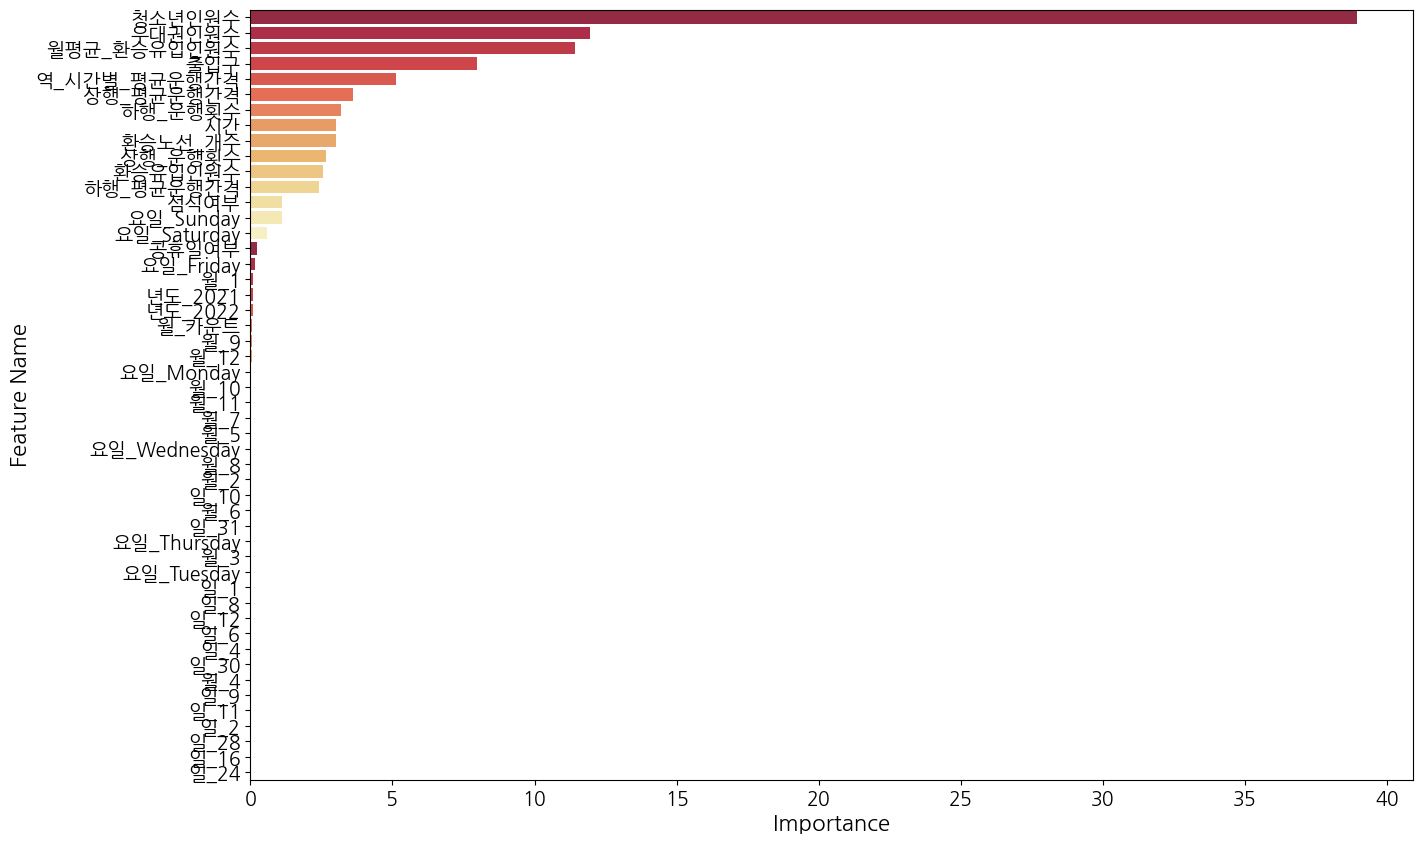

Performance Evaluations...:  2026-01-21 02:18:54.927310
Performance: 
   [Info] CatBoost (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


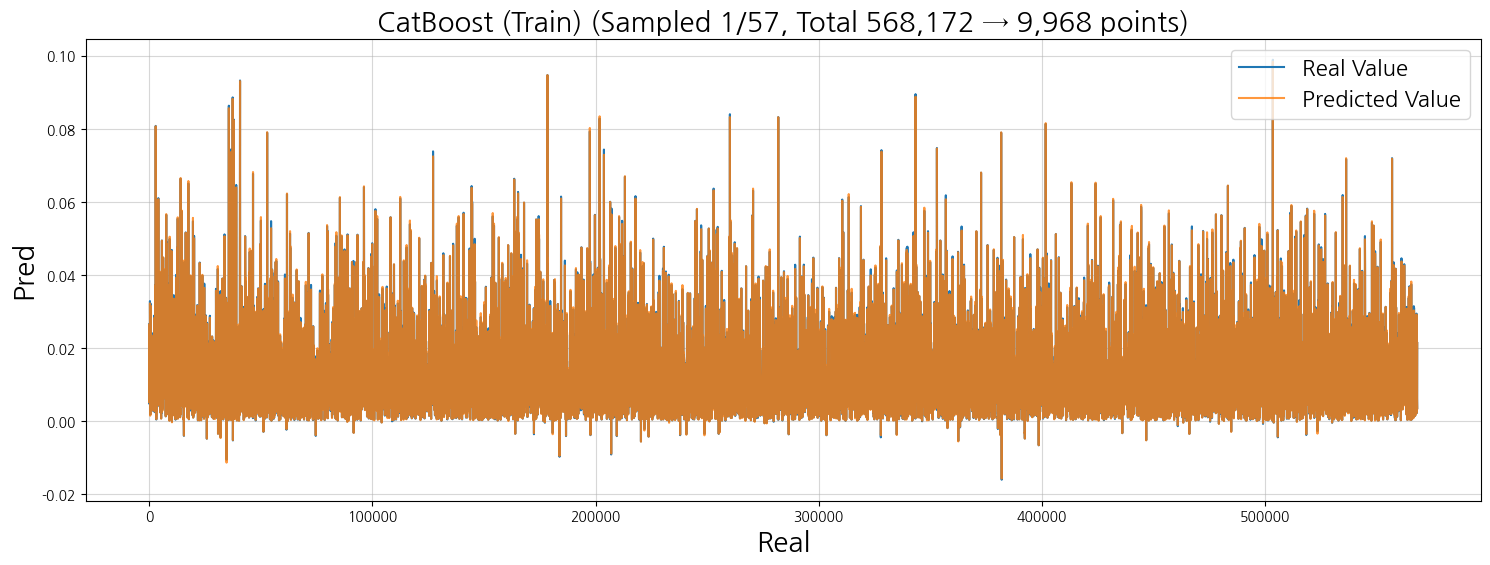

   [Info] CatBoost (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


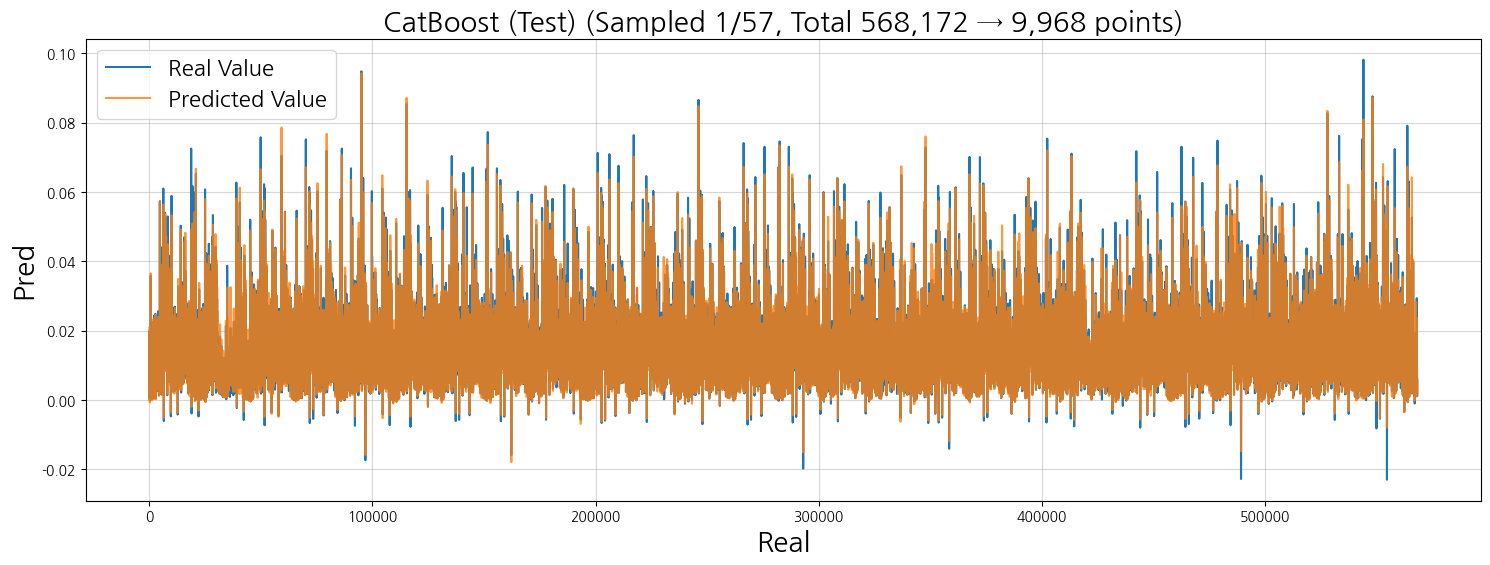

Algorithm            Dataset   RMSE    MSPE    MAE   MAPE  MedAE  MedAPE  \
0  CatBoost          Train set 0.0004  6.4533 0.0003 0.0658 0.0002  0.0228   
1  CatBoost     Validation(CV) 0.0008 12.6165 0.0005 0.1028 0.0003  0.0333   
2  CatBoost           Test set 0.0022  4.9473 0.0014 0.1914 0.0008  0.0795   
3  CatBoost  Entire population 0.0016  5.7003 0.0008 0.1286 0.0004  0.0415   

      R2  
0 0.9989  
1 0.9956  
2 0.9702  
3 0.9834

   [Save] CatBoost Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_CatBoost_20260121_021856.pkl
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_CatBoost_20260121_021856.json

   Modeling Completed. Summary of Performance (Regression)


Saved total performance to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Result/Performance_ML(Trial10)(Experiment1).csv
Saved total parameters to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Result/Hyperparams_ML(Trial10).csv
Saved total results object to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/Best_Result_ML(Trial10)(Experiment1).pkl


In [11]:
# Setting
algorithm_list = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
TUNE_TRIALS = 10
# feature_set = [X_colbasic, X_colbasic+X_colweather, X_colbasic+X_colweather+X_colecon]
feature_set = [X_colbasic]


# ML 실행
for i, subset in enumerate(feature_set):
    results_ML, scores_ML = modeling_ML(
        algos=algorithm_list,
        X_train=X_train[subset], Y_train=Y_train, X_test=X_test[subset], Y_test=Y_test,
        X_colname=subset,
        params=None, # 특정 알고리즘
        tune_trials=TUNE_TRIALS, # 최적화 여부
        cv_splits=CV_SPLITS,
        tune_metric=TUNE_METRIC,
        shap=not SHAP, 
        X_selected=None, # shap에서만 작동
        interaction=not INTERACTION,
        interaction_samples=INTERACTION_SAMPLES, 
        X_top_display=X_TOP_DISPLAY, 
        label_list=LABEL_LIST,
        save_name=SAVE_NAME_ML+'(Trial'+str(TUNE_TRIALS)+')(Experiment'+str(i+1)+').csv',
    )
    

## Deep Learning

In [9]:
# # Setting
# algorithm_list = ['MLP', 'CNN']
# TUNE_TRIALS = None
# # TUNE_TRIALS = 10

# # DL 실행
# results_DL, scores_DL = modeling_DL(
#     algos=algorithm_list,
#     X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
#     node_list=None, # 특정 알고리즘
#     validation_split=VALIDATION_SPLIT,
#     validation_data=VALIDATION_DATA,
#     tune_trials=TUNE_TRIALS, # 최적화 여부
#     tune_metric=TUNE_METRIC_DL,
#     epochs=EPOCHS-500,
#     batch_size=BATCH_SIZE,
#     earlystop_patient=None,
#     shap_display=False,
#     label_list=LABEL_LIST,
#     random_state=RANDOM_STATE,
# )

▶ Detected Task Type: [ Regression ] (Target: continuous)

   Running Deep Learning Algorithm: CNN (Regression)
[Info] Starting Hyperparameter Optimization (Trials: 10)...


  0%|          | 0/10 [00:00<?, ?it/s]

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

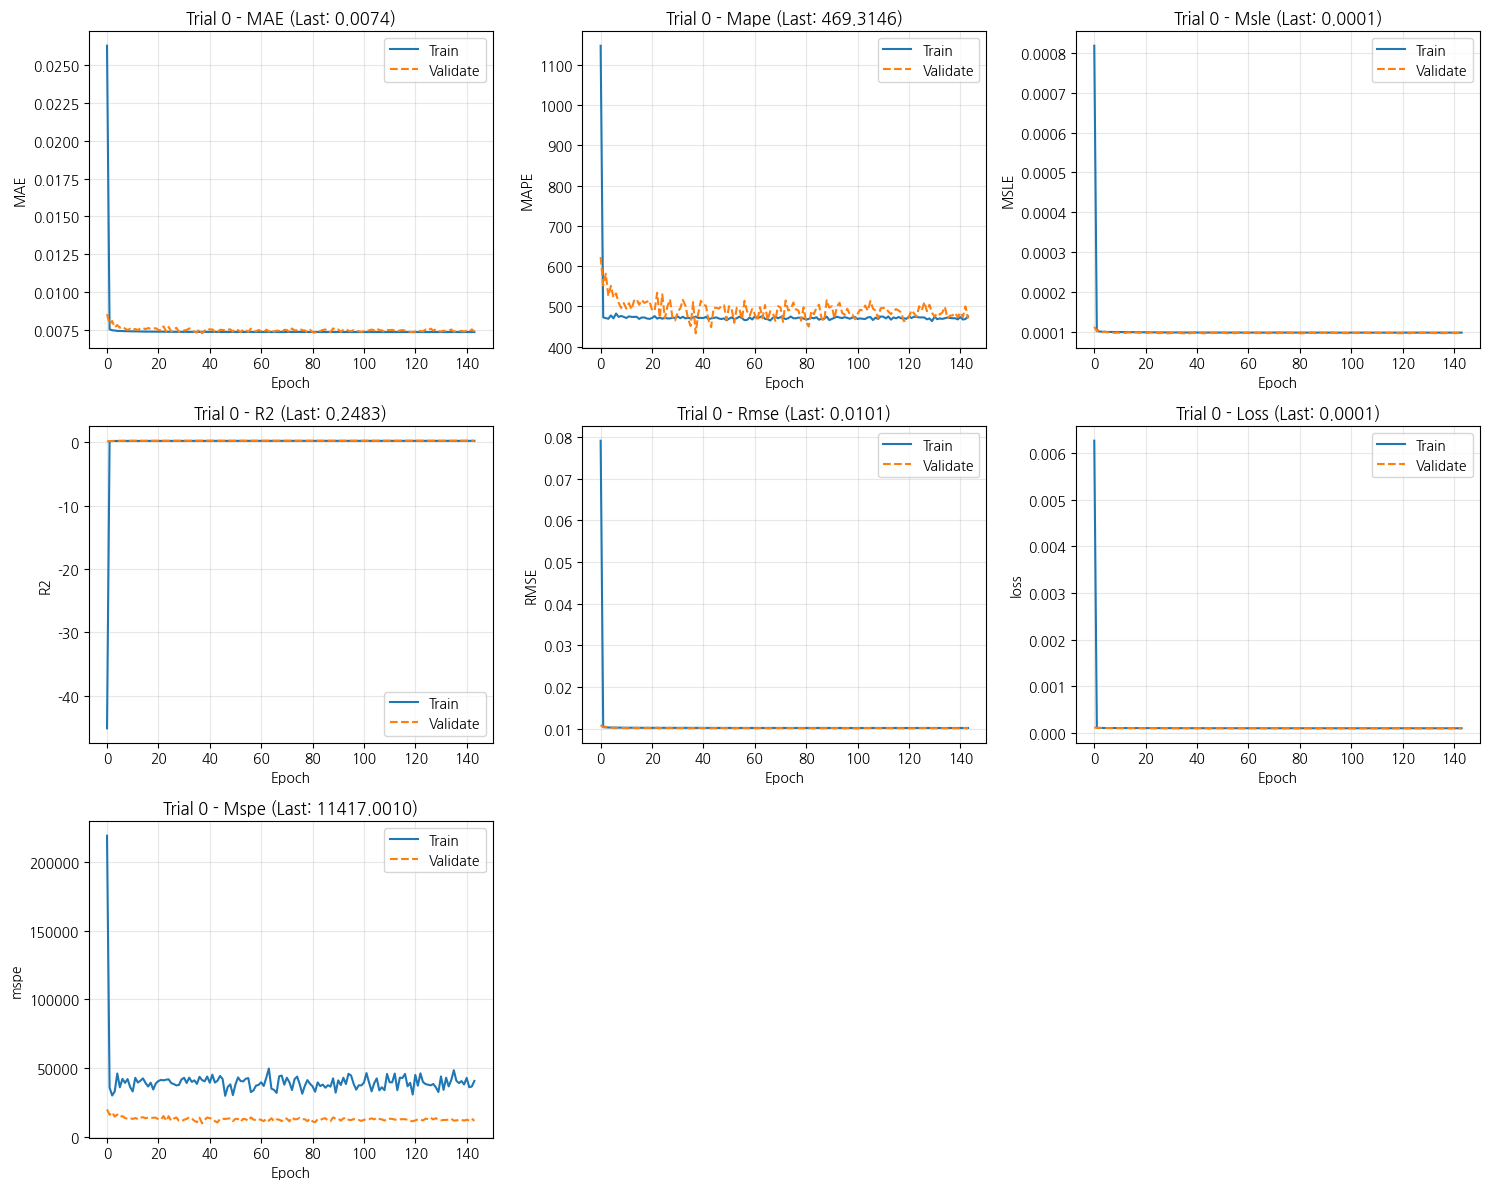

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

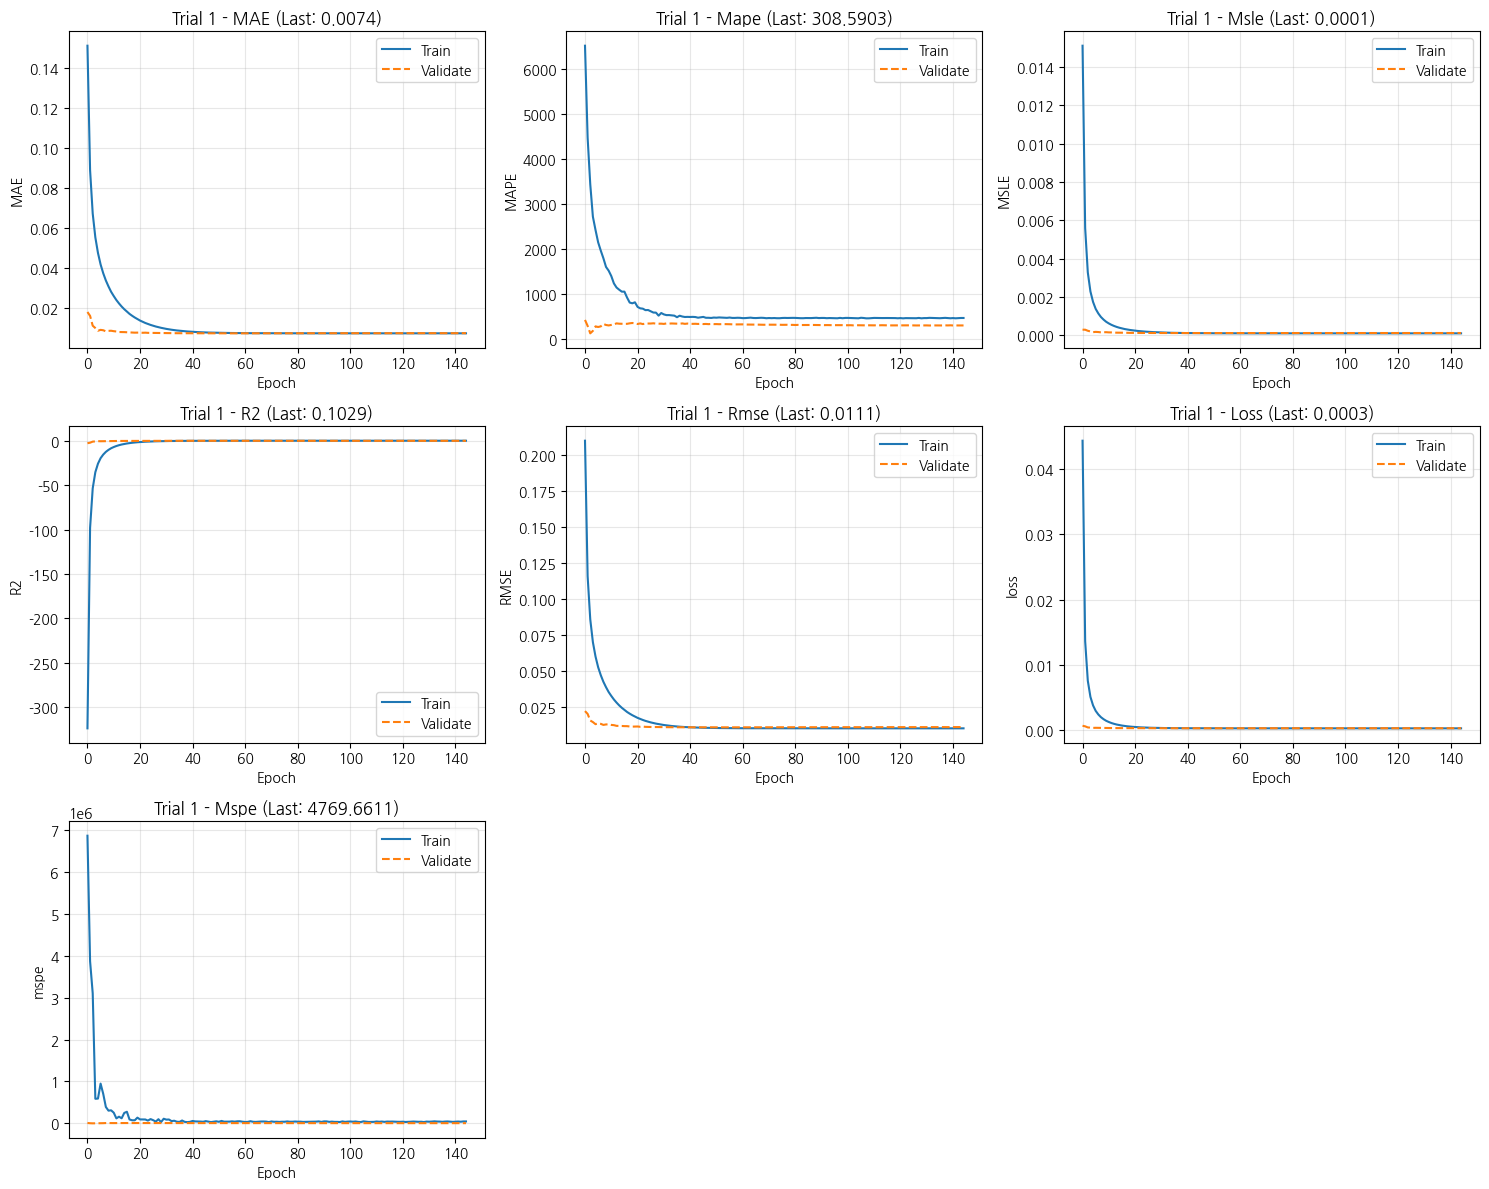

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

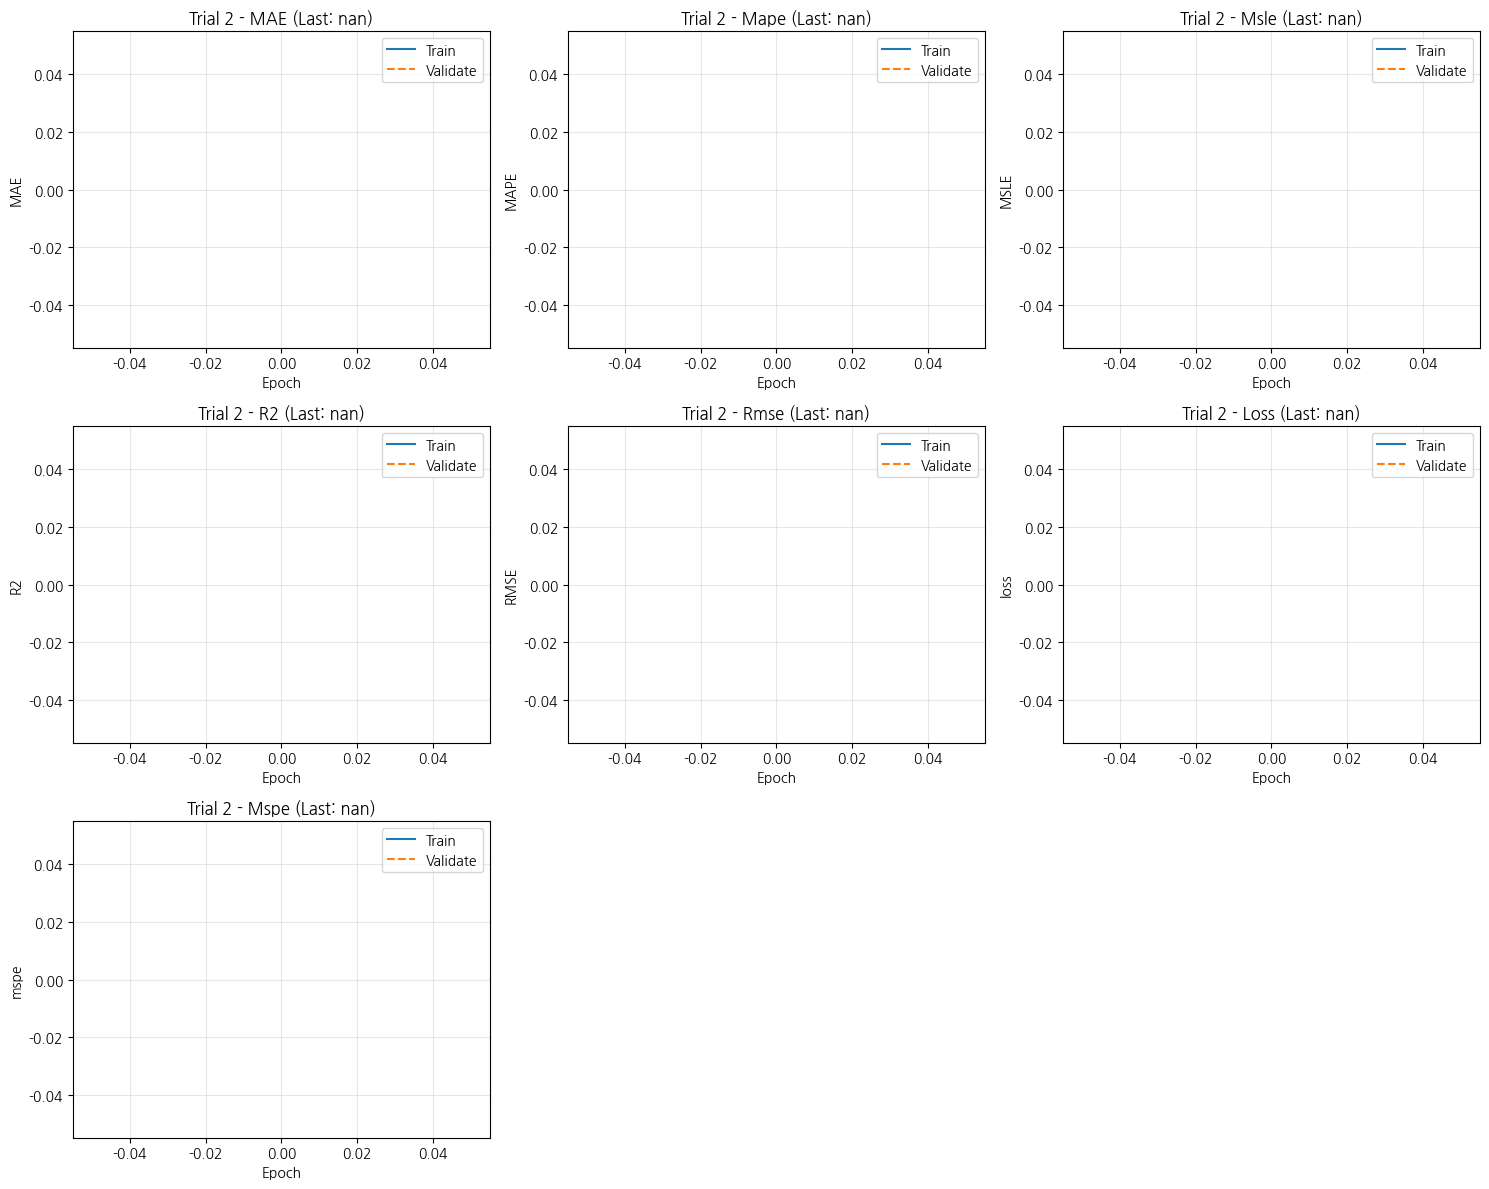

Training Progress:   4%|██▍                                                       | 43/1000 [1:25:44<2:31:13,  9.48s/it]

[W 2026-01-22 12:32:08,926] Trial 2 failed with parameters: {'n_layers': 3, 'l2_regularization': 1.1561947876935803e-06, 'batch_normalization': False, 'hidden_activation': 'relu', 'dropout': 0.47578538927276554, 'batch_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.0006340596856830734, 'base_filters': 32, 'kernel_size': 5} because of the following error: The value nan is not acceptable.
[W 2026-01-22 12:32:08,928] Trial 2 failed with value nan.


Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

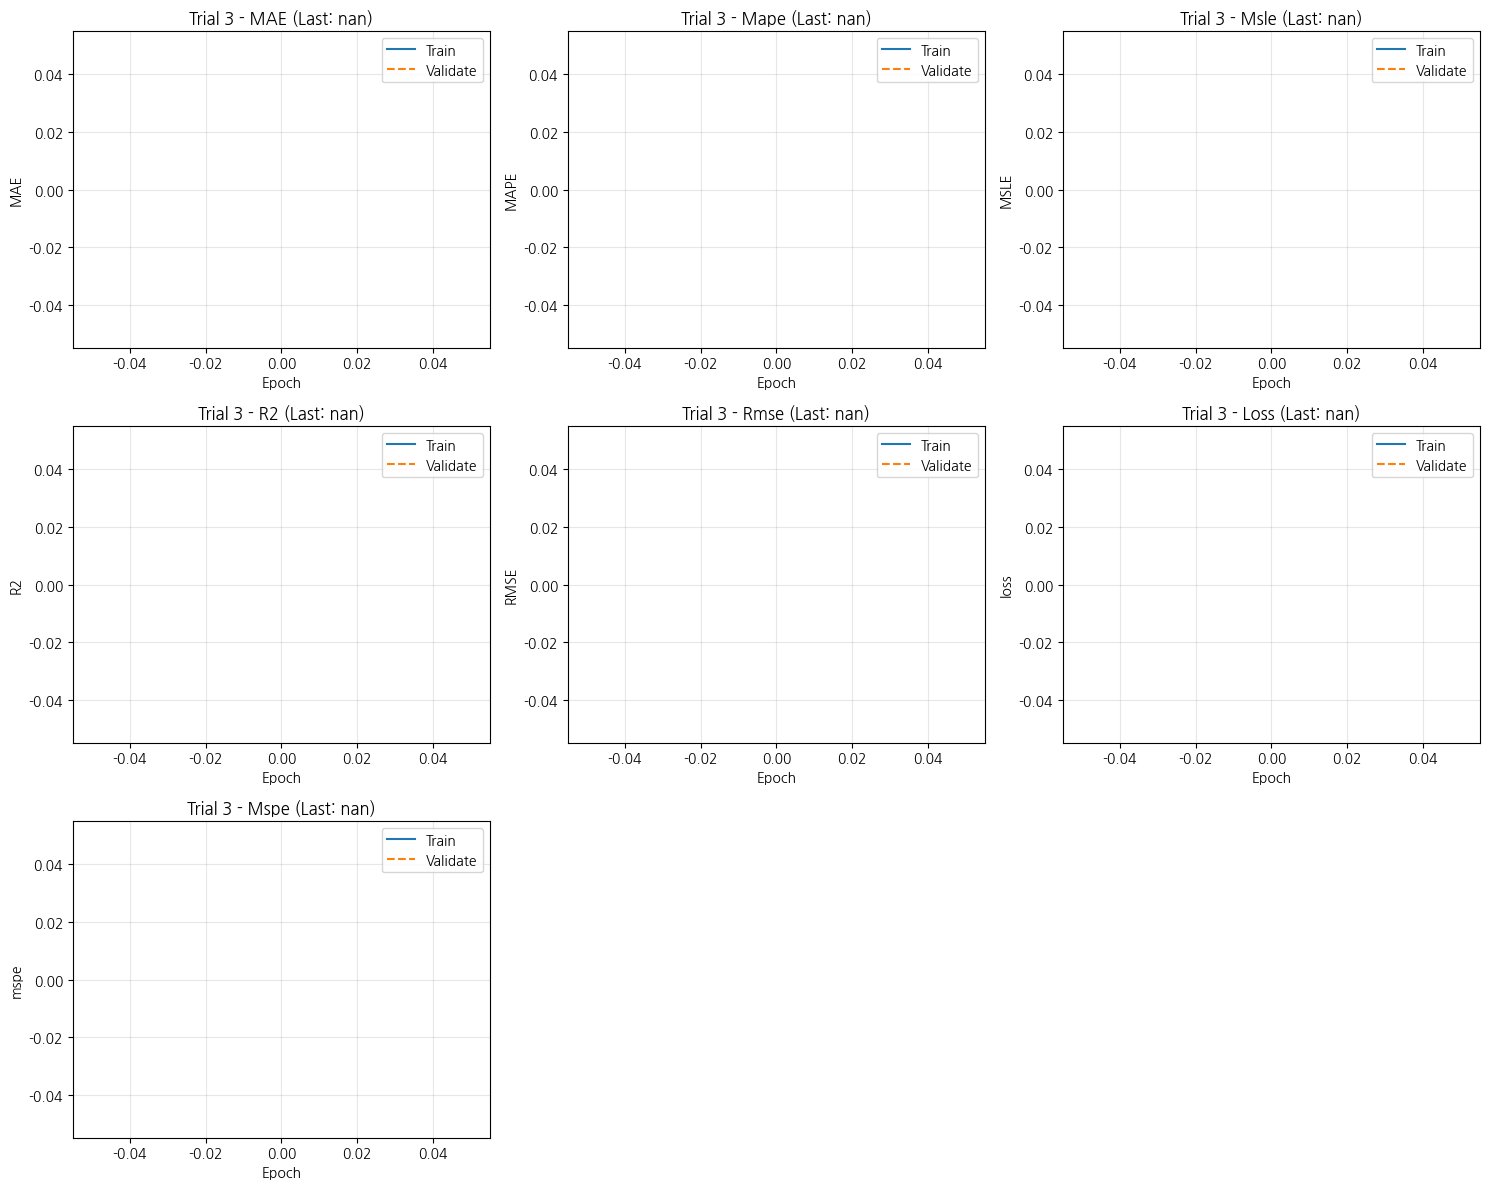

Training Progress:   4%|██▍                                                       | 43/1000 [2:45:08<2:31:13,  9.48s/it]

[W 2026-01-22 13:51:32,517] Trial 3 failed with parameters: {'n_layers': 2, 'l2_regularization': 6.921373592320543e-05, 'batch_normalization': False, 'hidden_activation': 'selu', 'dropout': 0.0121996541965953, 'batch_size': 32, 'optimizer': 'sgd', 'learning_rate': 0.001408716269533105, 'base_filters': 64, 'kernel_size': 3} because of the following error: The value nan is not acceptable.
[W 2026-01-22 13:51:32,519] Trial 3 failed with value nan.


Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

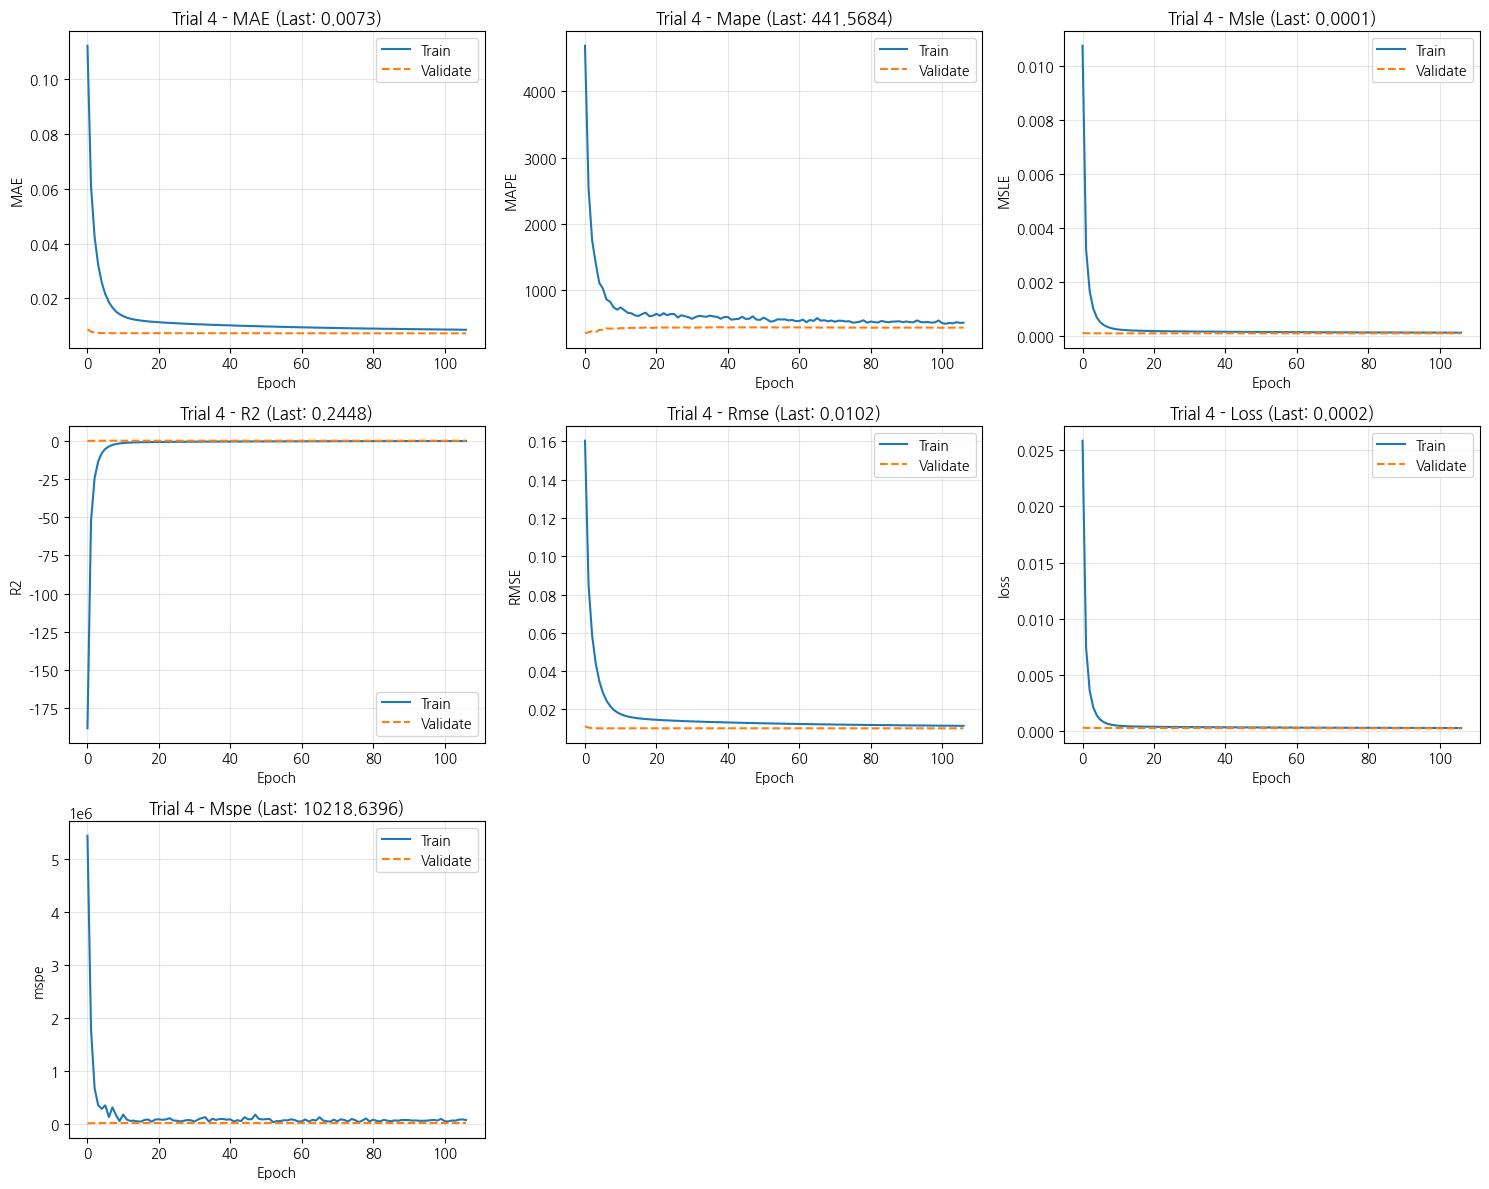

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

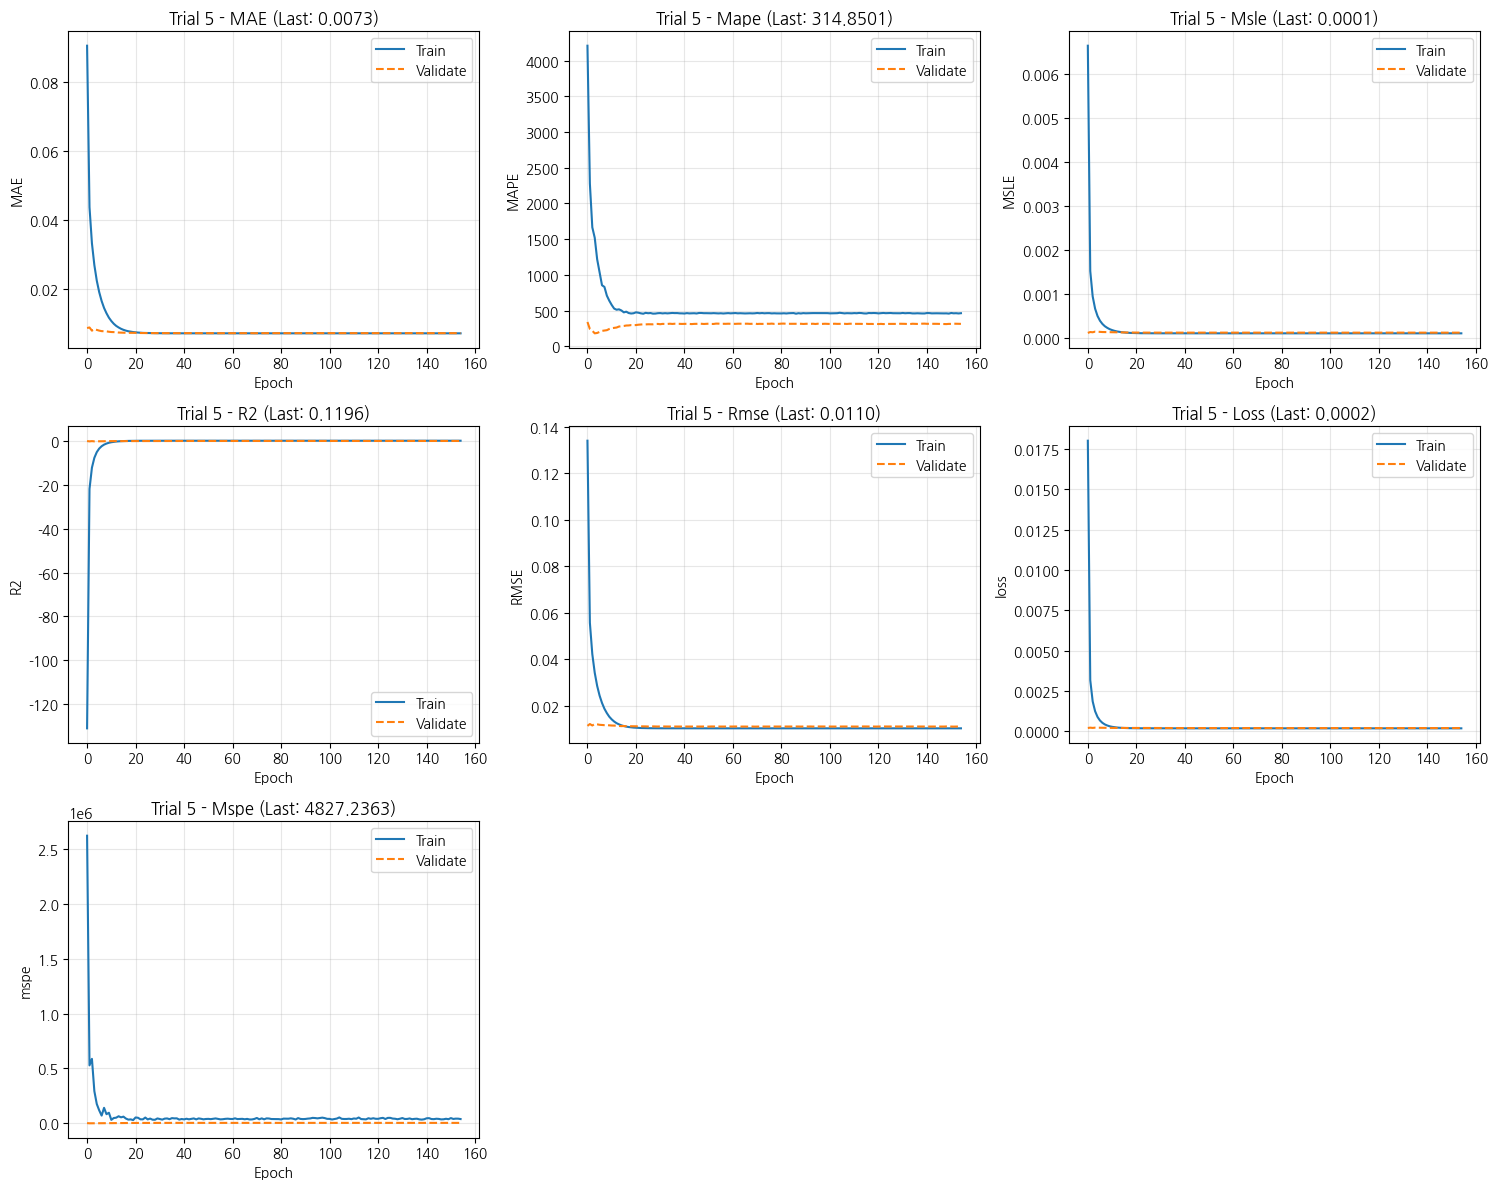

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

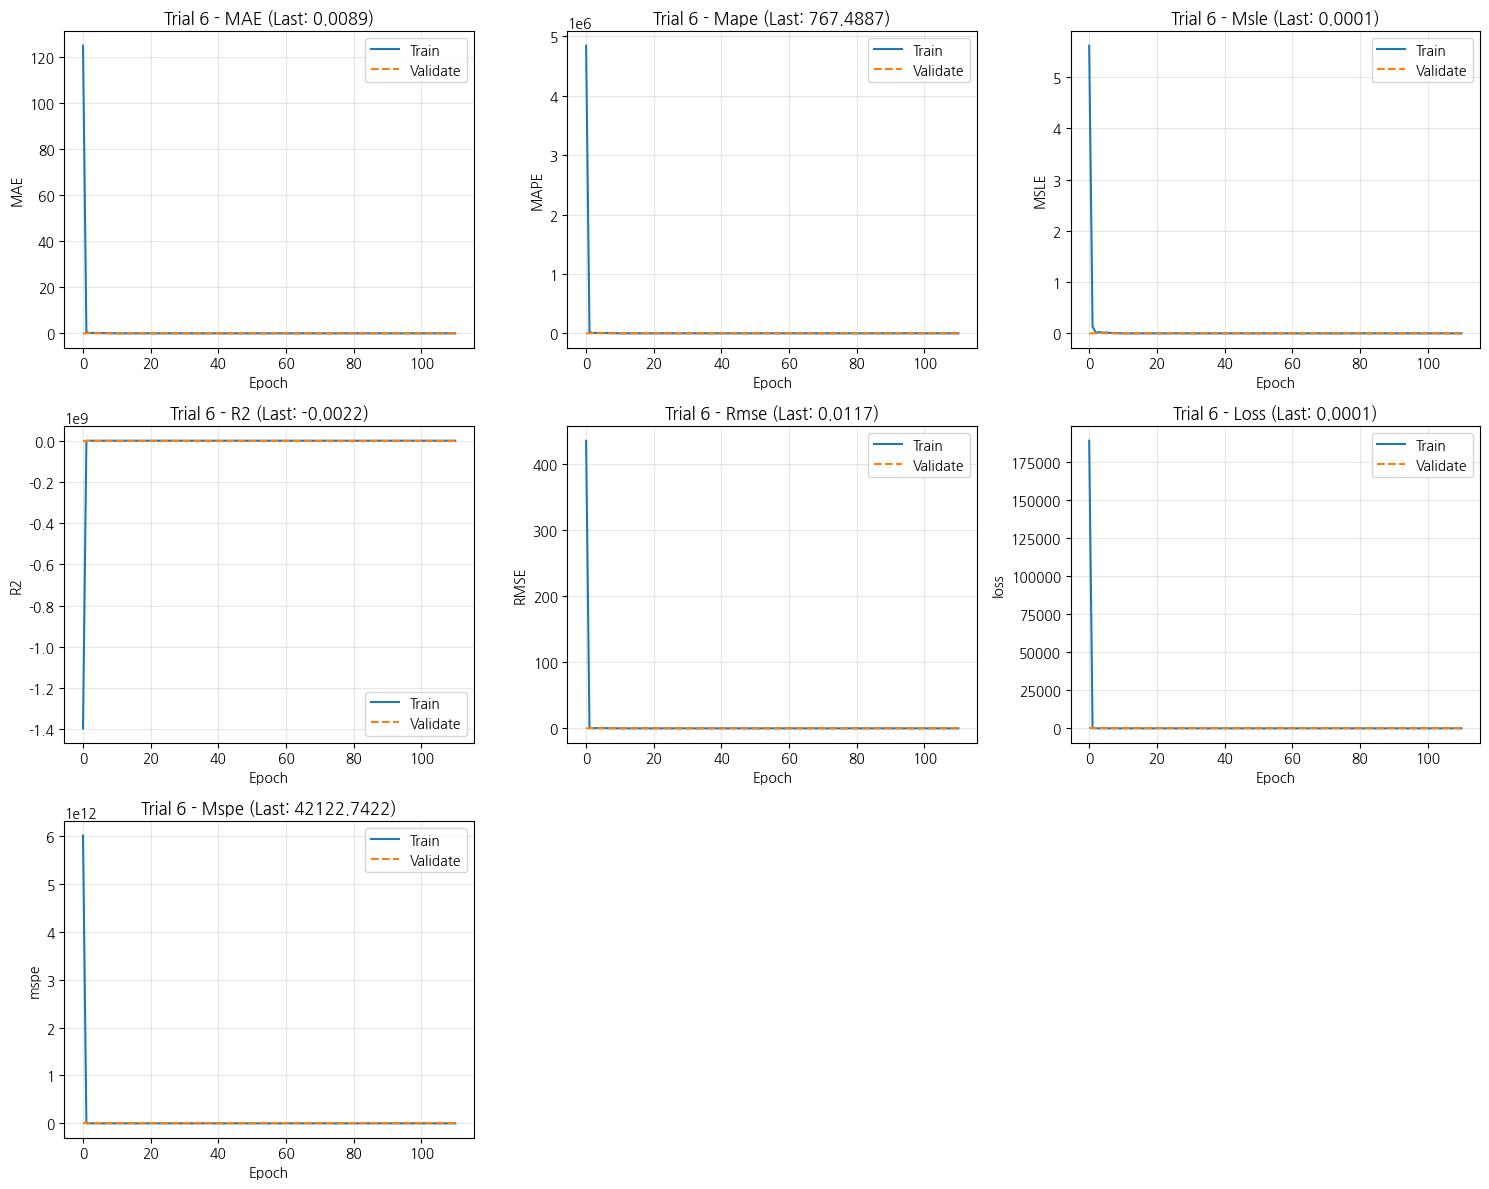

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

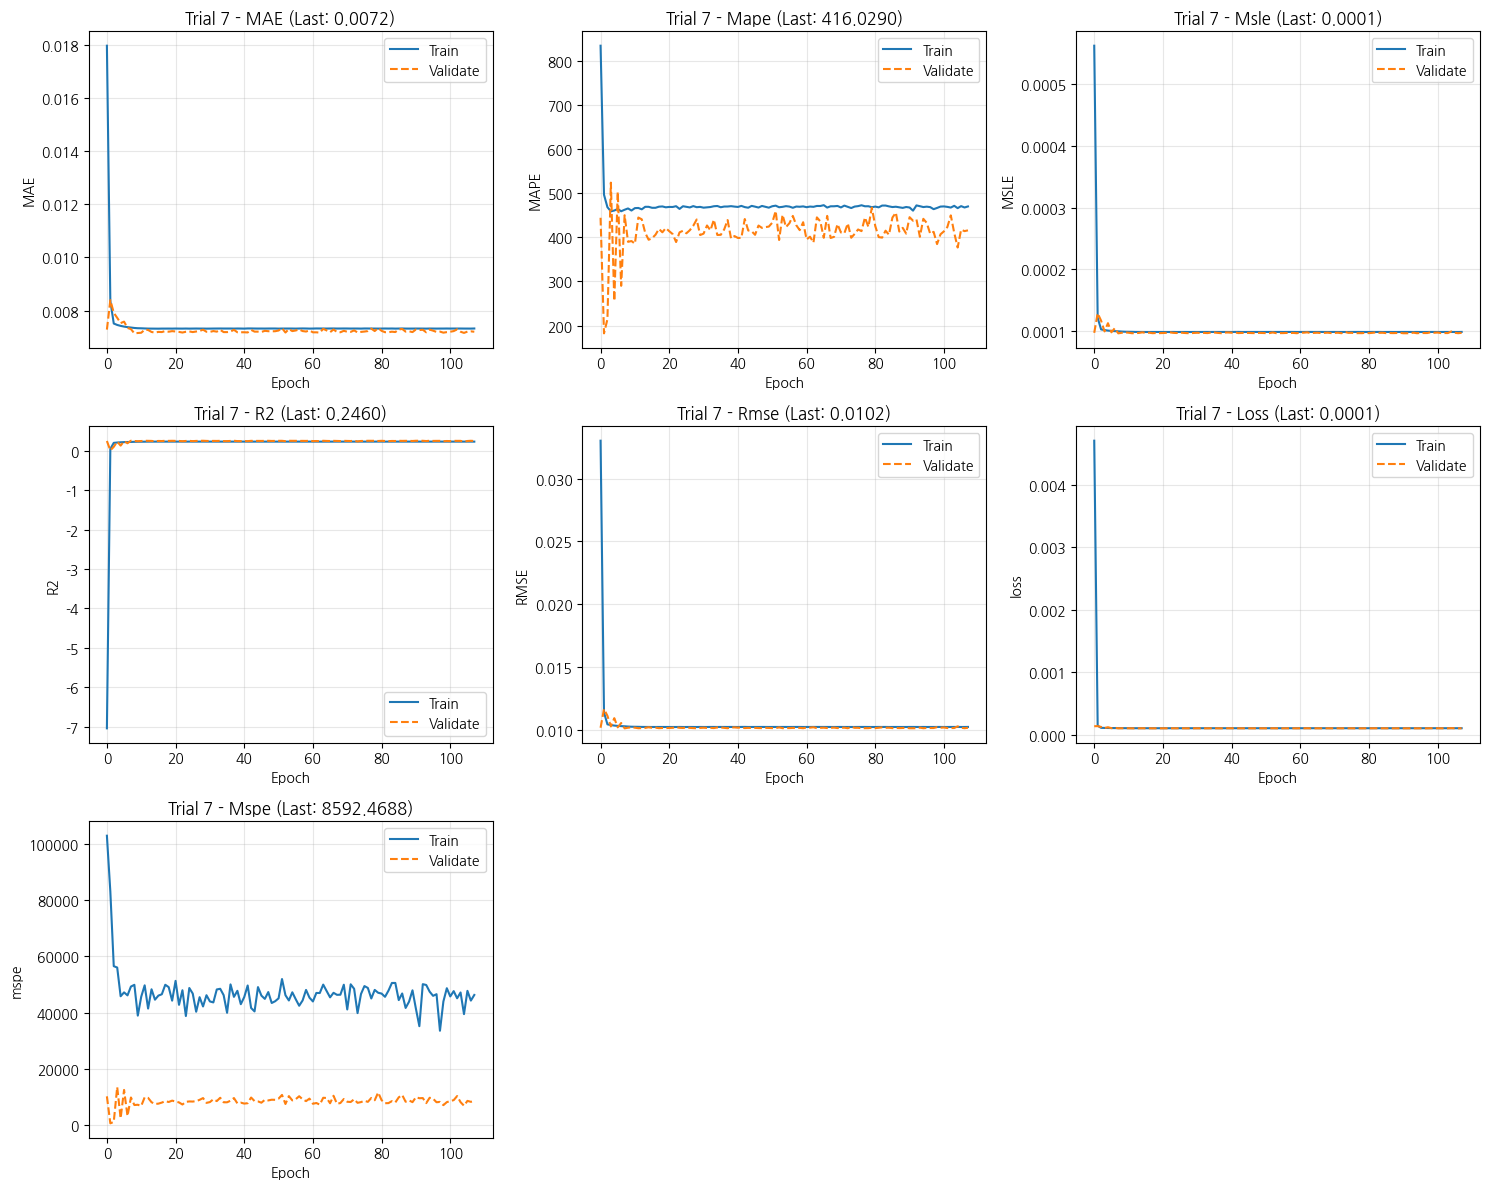

Training Progress:   0%|                                                                       | 0/1000 [00:40<?, ?it/s]


Trial:  0 State:  1 Best Epoch:  43
Metrics:  {'MAE': 0.007356754969805479, 'MAPE': 470.08441162109375, 'MSLE': 9.896533447317779e-05, 'R2': 0.2298697829246521, 'RMSE': 0.010218759067356586, 'loss': 0.00010596499487292022, 'mspe': 40714.97265625, 'val_MAE': 0.0073254005847755285, 'val_MAPE': 4.484056669987563, 'val_MSLE': 9.699744987301528e-05, 'val_R2': 0.25083909906637525, 'val_RMSE': 0.010122196194772472, 'val_loss': 0.00010398351878393441, 'val_mspe': 10249.0009765625, 'val_MSPE': 10251.620605967331, 'val_MedAE': 0.0052853075419684445, 'val_MedAPE': 0.4647339318696874}

Trial:  1 State:  1 Best Epoch:  44
Metrics:  {'MAE': 0.007830445654690266, 'MAPE': 488.9988098144531, 'MSLE': 0.00010794906847877428, 'R2': 0.16030699014663696, 'RMSE': 0.010670293122529984, 'loss': 0.0003326278238091618, 'mspe': 38370.73046875, 'val_MAE': 0.007337452102129097, 'val_MAPE': 3.461532355752069, 'val_MSLE': 0.00011185144103365019, 'val_R2': 0.13656098690012775, 'val_RMSE': 0.010866834003133404, 'val_lo

Training Progress:   0%|                                                                       | 0/1000 [00:00<?, ?it/s]

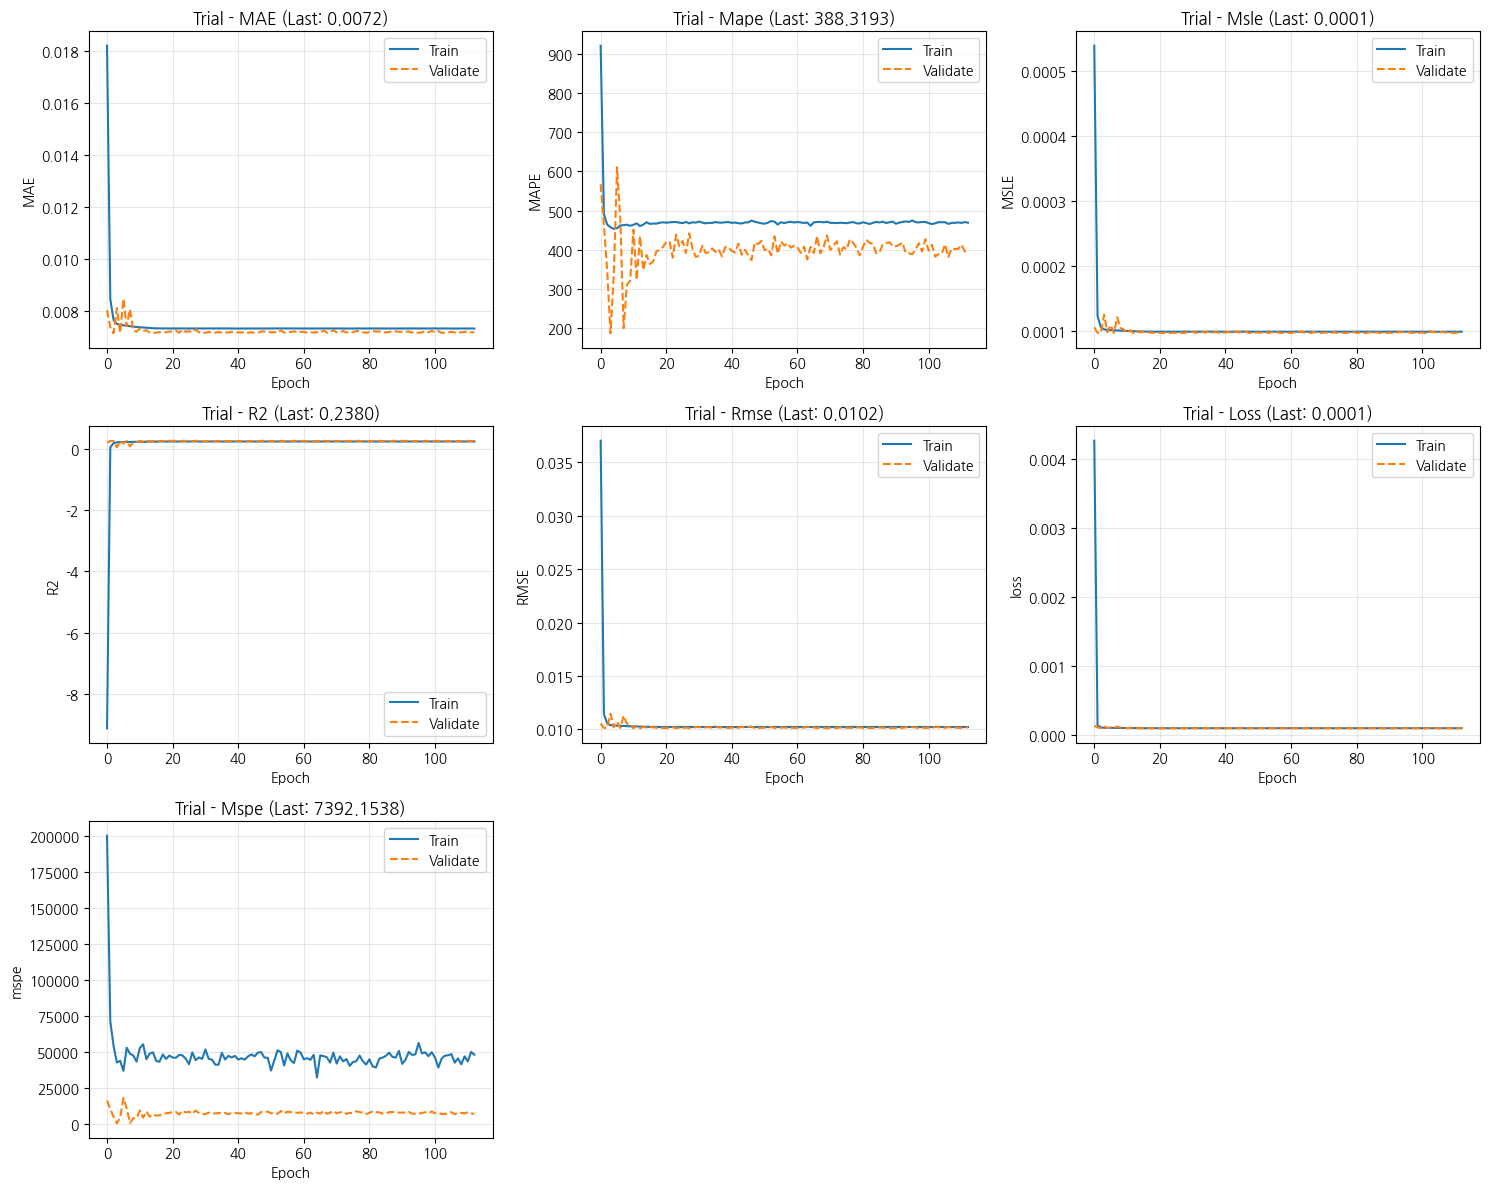

Training Progress:  11%|██████▎                                                 | 113/1000 [1:25:53<11:14:09, 45.60s/it]


   [Save] CNN Checkpoint Saved:
     - Model : /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_model_CNN_20260122_191228.keras
     - Params: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/best_params_CNN_20260122_191228.json
Performance: 
   [Info] CNN (Train): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


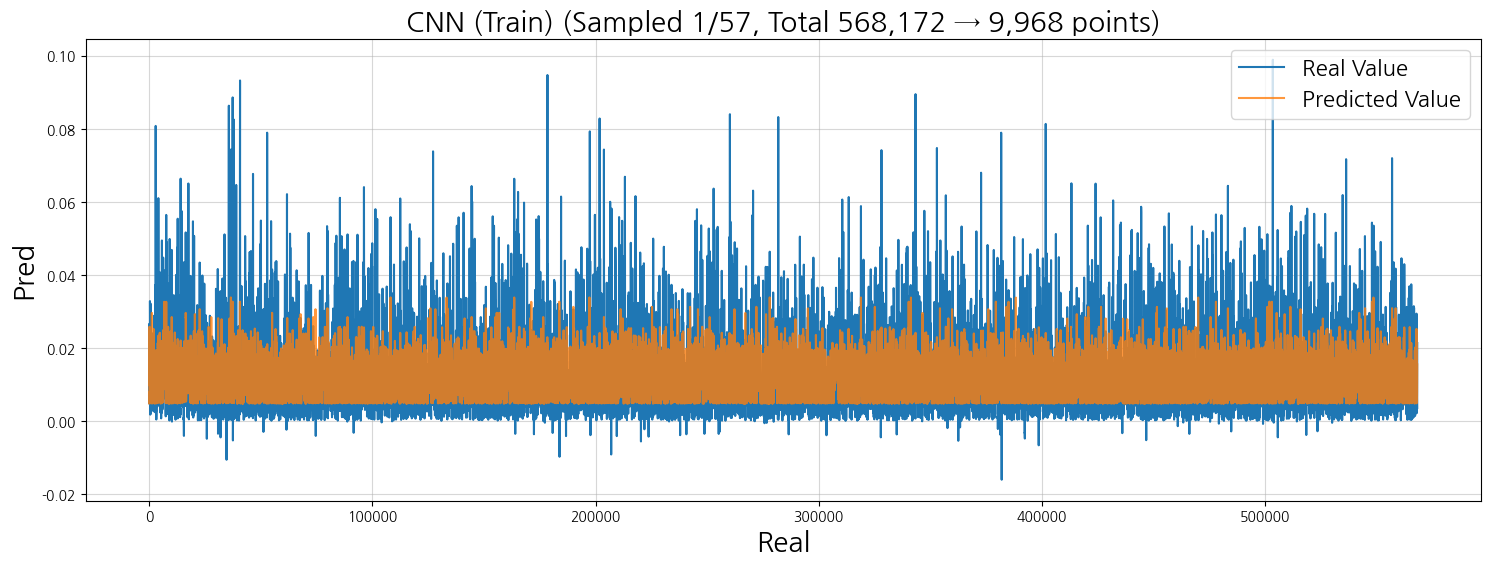

   [Info] CNN (Test): Data too large. Plotting every 57-th point. (Sampled 1/57, Total 568,172 → 9,968 points)


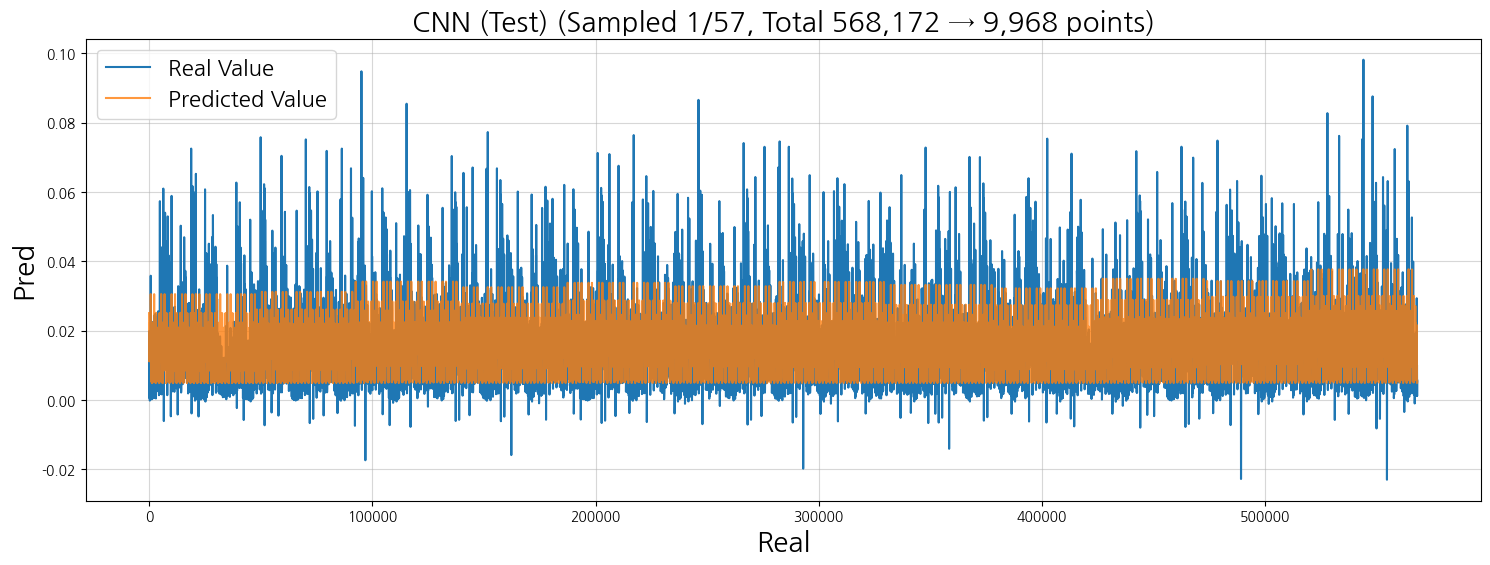


   Modeling Completed. Summary of Performance (regression)


Saved total performance to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Result/Performance_DL(Trial10)(Experiment1).csv
Saved total parameters to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Result/Hyperparams_DL(Trial10).csv
Saved total results object to: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model/Best_Result_DL(Trial10)(Experiment1).pkl


In [14]:
# Setting
# algorithm_list = ['MLP', 'CNN']
algorithm_list = ['CNN']
TUNE_TRIALS = 10
# feature_set = [X_colbasic, X_colbasic+X_colweather, X_colbasic+X_colweather+X_colecon]
feature_set = [X_colbasic]


# ML 실행
for i, subset in enumerate(feature_set):
    results_DL, scores_DL = modeling_DL(
        algos=algorithm_list,
        X_train=X_train[subset], Y_train=Y_train, X_test=X_test[subset], Y_test=Y_test,
        node_list=None, # 특정 알고리즘
        validation_split=VALIDATION_SPLIT,
        validation_data=VALIDATION_DATA,
        tune_trials=TUNE_TRIALS, # 최적화 여부
        tune_metric=TUNE_METRIC_DL,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        earlystop_patient=None,
        shap_display=False,
        label_list=LABEL_LIST,
        random_state=RANDOM_STATE,
        save_name=SAVE_NAME_DL+'(Trial'+str(TUNE_TRIALS)+')(Experiment'+str(i+1)+').csv',
    )
    

In [15]:
best_model, best_params = Loading_ModelBestParams(algo_name='CNN')

▶ Searching Directory: /mnt/c/DataScience/[DIVE]/Project/SubwayPrediction/Model
Loading Model: CNN
   - File: best_model_CNN_20260122_191228.keras
   - Successfully Loaded.


# Others

In [2]:
# 전처리
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    print(df.shape)
    
    # 수송인원 높은 역 필터링
    # top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', 
    #               '을지로입구', '종각', '가산디지털단지', '서울대입구', '성수', '혜화', '양재', 
    #                '사당', '명동', '압구정', '수유', '연신내', '건대입구', '합정', '신사', '광화문', 
    #                 '시청', '여의도', '경복궁', '안국', '종로3가'] 
    
    top_stations = ['홍대입구', '강남', '서울역', '신림', '잠실', '고속터미널', '선릉', '역삼', '신도림', '을지로입구'] 
    
    df = df[df['역명'].isin(top_stations)].reset_index(drop=True)
    
    selected_columns = df.columns
    
    # 제외할 변수 지정
    excluded_columns = ['역명', '면적', '승강장혼잡도2', '승강장혼잡도1', '날짜', '수송인원수', 'L_total', 'λ_total',
                        'W_total', 'W_환승', 'λ_환승', 'W_승차', 'λ_승차', '승강장_혼잡도', '요일구분', '승하차인원', '일별_승하차인원_합', '호선'
                        ,'시간대별_환승_승객_수','시간대별_승하차_비율']
    
    feature_columns = [col for col in selected_columns if col not in excluded_columns]
    
    # 독립 변수와 종속 변수 분리
    X = df[feature_columns]
    y = df['승강장_혼잡도']
    
    # 학습용과 테스트용 데이터로 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 결과를 딕셔너리 형태로 반환
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'feature_columns': feature_columns,
        'scaler': scaler,  # 추가
        'df_train': df.iloc[X_train.index],
        'df_test': df.iloc[X_test.index]
    }
    
    return data

# 데이터 전처리
# file_location = os.path.join('/mnt', 'z', '내 드라이브', 'Research', 'SavedData', 'KoSubway', 'df_subway_prep_20241117.csv')
file_location = r'Z:\내 드라이브\Research\SavedData\KoSubway\df_subway_prep_20241117.csv'
df = preprocess_data(file_location)
df_new = pd.concat([df['df_train'], df['df_test']], axis=0)
df_using = pd.concat([df['df_train'][df['feature_columns']], df['df_test'][df['feature_columns']]], axis=0)
print(df_new.shape, df_using.shape)

(1649016, 71)
(553294, 71) (553294, 51)


In [3]:
print(df_new.shape, df_using.shape)

(553294, 71) (553294, 51)


In [18]:
df_stat = df_new.copy()
days = ['요일_Monday', '요일_Tuesday', '요일_Wednesday', '요일_Thursday', '요일_Friday', '요일_Saturday', '요일_Sunday']
df_stat['요일'] = df_stat[days].idxmax(axis=1)
label_map = {day: idx for idx, day in enumerate(days)}
df_stat['요일'] = df_stat['요일'].map(label_map)

In [22]:
df_stat.columns

Index(['날짜', '호선', '역명', '시간', '승차인원', '하차인원', '우대권인원수', '청소년인원수', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '습도(%)', '적설(cm)', '승하차인원', '출입구', '섬식여부',
       '환승노선_개수', '면적', '수송인원수', '환승유입인원수', '승강장혼잡도1', '승강장혼잡도2', '지하철요금',
       '달러 환율', '승하차인원차', '보통휘발유', '자동차용경유', '실업률(%)', '청년실업률(%)',
       '동행지수 순환변동치', '선행지수 순환변동치', '서울_인구(천명)', '서울_인구밀도', '수도권_인구(천명)',
       '수도권_인구밀도', '자동차등록대수(만대)', '기준금리', '한국CPI', 'CPI_대비_지하철요금',
       '요일_Saturday', '요일_Sunday', '공휴일여부', '요일_Monday', '요일_Tuesday',
       '요일_Wednesday', '요일_Thursday', '요일_Friday', '상선 혼잡도', '하선 혼잡도', '요일구분',
       '상행_평균운행간격', '하행_평균운행간격', '상행_운행횟수', '하행_운행횟수', '역_시간별_평균운행간격', '월_카운트',
       '월평균_환승유입인원수', '일별_승하차인원_합', '시간대별_승하차_비율', '시간대별_환승_승객_수', 'λ_승차',
       'λ_환승', 'λ_total', 'W_승차', 'W_환승', 'W_total', 'L_total', '승강장_혼잡도', '주',
       '년도', '월', '요일'],
      dtype='object')

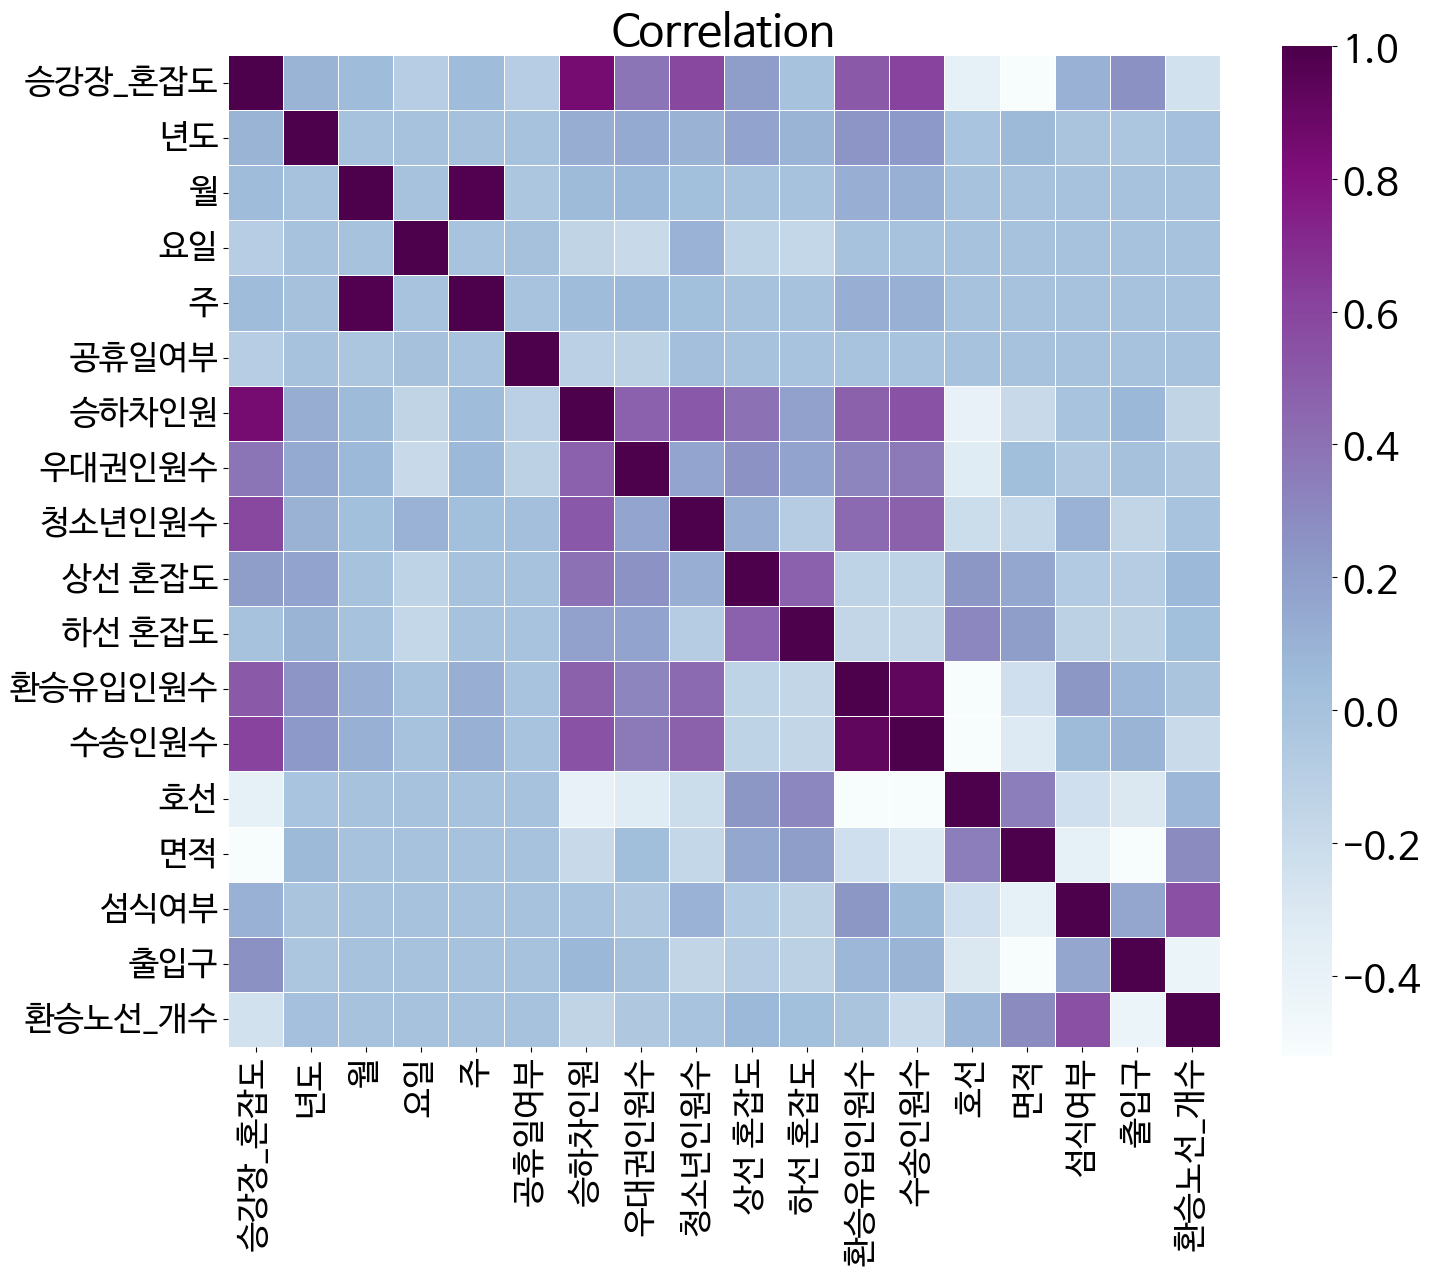

In [30]:
df_corr = df_stat[['승강장_혼잡도', '년도', '월', '요일', '주', '공휴일여부', 
         '승하차인원', '우대권인원수', '청소년인원수', '상선 혼잡도', '하선 혼잡도', '환승유입인원수', '수송인원수', 
         '호선', '면적', '섬식여부', '출입구', '환승노선_개수']].corr()
plot_heatmap(df_corr, fontsize=30, save_local=False)
plt.show()

# Descriptive

In [9]:
pd.concat([pd.concat([df_new['호선'].value_counts(), df_new['호선'].value_counts(normalize=True)], axis=1).sort_index(),
           df_new[['호선','역명']].drop_duplicates().groupby(['호선']).sum()], axis=1)

count  proportion                      역명
호선                                            
1    41610      0.0752                     서울역
2   346748      0.6267  을지로입구신림신도림홍대입구선릉역삼잠실강남
3    41610      0.0752                   고속터미널
4    41610      0.0752                     서울역
7    41610      0.0752                   고속터미널
8    40106      0.0725                      잠실

In [10]:
df_new[['승강장혼잡도1']].describe().T

count    mean     std    min     25%     50%     75%      max
승강장혼잡도1 553,294.0000 59.9765 60.5998 0.2500 17.4044 38.1930 81.0391 502.3289

In [ ]:
# fig = px.box(df_new, x='호선', y='승강장혼잡도1', notched=True)
# fig.update_layout(width = 800, height = 500, bargap=0.1,
#                   yaxis_title='혼잡도',
#                   yaxis={'categoryorder':'total descending'},
#                   font=dict(size=16, color="black"))
# fig.show()

In [ ]:
# fig = px.box(df_new, x='역명', y='승강장혼잡도1', notched=True)
# fig.update_layout(width = 800, height = 500, bargap=0.1,
#                   yaxis_title='혼잡도', 
#                   xaxis={'categoryorder':'total descending'},
#                   font=dict(size=16, color="black"))
# fig.show()

In [ ]:
# descriptive_KK(df, target='혼잡도')

# Performance

## SCI

In [ ]:
# 데이터로딩
file_location = r'C:\DataScience\[DEBA]\Project-SubwayPrediction\Result\Performance_DataWizardd_20241114.xlsx'
df_result1 = pd.read_excel(file_location, sheet_name='승강장혼잡도(1)_기존', header=1)
# df_result1 = df_result1.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'])
df_result2 = pd.read_excel(file_location, sheet_name='승강장혼잡도(2)_리틀', header=1)
# df_result2 = df_result2.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'])
display(df_result1.head(), df_result2.head())

In [ ]:
df_rank = pd.DataFrame(np.zeros((7,12)))
for each1, each2 in df_result1.drop_duplicates().values:
    df_sub = df_result1[df_result1['Unnamed: 0'] == each1]
    df_sub = df_sub[df_sub['Unnamed: 1'] == each2]
#     display(table_highlight(df_sub, minmax='min', axis=0, new_index=None))
    df_rank = df_rank.add(df_sub.rank(method='min').values)
df_rank.columns = list(df_sub.columns)
df_rank.index = list(df_result1['Unnamed: 2'].unique())
display(table_highlight(df_rank.iloc[:, 5:] / 39, minmax='min', axis=0, new_index=None))

In [ ]:
df_opt = pd.DataFrame()
for algo in df_result1['Unnamed: 2'].unique():
    df_sub = df_result1[df_result1['Unnamed: 2'] == algo][['MSPE', 'MAPE', 'MedAPE']]
    df_opt = pd.concat([df_opt, df_sub.mean()], axis=1)
df_opt.columns = list(df_result1['Unnamed: 2'].unique())
df_opt.T.sort_values(by='MAPE')

## KCI

In [5]:
# 데이터로딩
# file_location = os.path.join('/mnt', 'c', 'DataScience', '[DEBA]', 'Project-SubwayPrediction(KCI)', 'Result', 'subway_result_kci.xlsx')
file_location = r'C:\DataScience\[DEBA]\[Project]\SubwayPrediction\Result\Performance_DataWizardd_KCI.xlsx'
top_stations = ['홍대입구', '강남', '서울역', '신림', '잠실', '고속터미널', '선릉', '역삼', '신도림', '을지로입구'] 
df_train = pd.read_excel(file_location, sheet_name='Train')
df_train = df_train[df_train['역명'].isin(top_stations)]
df_test = pd.read_excel(file_location, sheet_name='Test')

In [6]:
# Train
df_rank = pd.DataFrame(np.zeros((7,12)))
for each1, each2 in df_train.iloc[:,:2].drop_duplicates().values:
    df_sub = df_train[df_train['역명'] == each1]
    df_sub = df_sub[df_sub['호선'] == each2]
#     display(table_highlight(df_sub, minmax='min', axis=0, new_index=None))
    df_rank = df_rank.add(df_sub.rank(method='min').values)
df_rank.columns = list(df_sub.columns)
df_rank.index = list(df_train['알고리즘'].unique())
display(table_highlight(df_rank.iloc[:, 5:] / len(df_train.iloc[:,:2].drop_duplicates().values), minmax='min', axis=0, new_index=None))

# Test
df_rank = pd.DataFrame(np.zeros((7,12)))
for each1, each2 in df_test.iloc[:,:2].drop_duplicates().values:
    df_sub = df_test[df_test['역명'] == each1]
    df_sub = df_sub[df_sub['호선'] == each2]
#     display(table_highlight(df_sub, minmax='min', axis=0, new_index=None))
    df_rank = df_rank.add(df_sub.rank(method='min').values)
df_rank.columns = list(df_sub.columns)
df_rank.index = list(df_test['알고리즘'].unique())
display(table_highlight(df_rank.iloc[:, 5:] / len(df_test.iloc[:,:2].drop_duplicates().values), minmax='min', axis=0, new_index=None))

In [7]:
# Train
df_opt = pd.DataFrame()
for algo in df_train['알고리즘'].unique():
    df_sub = df_train[df_train['알고리즘'] == algo][['MSPE', 'MAPE', 'MedAPE']]
    df_opt = pd.concat([df_opt, df_sub.mean()], axis=1)
df_opt.columns = list(df_train['알고리즘'].unique())
df_opt = df_opt.T.sort_values(by='MAPE')
display(df_opt)

# Test
df_opt = pd.DataFrame()
for algo in df_test['알고리즘'].unique():
    df_sub = df_test[df_test['알고리즘'] == algo][['MSPE', 'MAPE', 'MedAPE']]
    df_opt = pd.concat([df_opt, df_sub.mean()], axis=1)
df_opt.columns = list(df_test['알고리즘'].unique())
df_opt = df_opt.T.sort_values(by='MAPE')
display(df_opt)

MSPE   MAPE  MedAPE
Random Forest     0.0000 0.0020  0.0686
MLP               0.0016 0.0145  0.7852
CNN               0.0038 0.0312  1.7671
XGBoost           0.0253 0.0894  6.0759
LightGBM          0.0211 0.0897  6.6431
CatBoost          0.0381 0.1147  8.8312
Linear Regression 0.7176 0.4336 30.8128

MSPE   MAPE  MedAPE
Random Forest     0.0001 0.0032  0.1234
MLP               0.0017 0.0124  0.5244
CNN               0.0013 0.0137  0.6727
XGBoost           0.0091 0.0534  3.3208
LightGBM          0.0122 0.0537  3.3800
CatBoost          0.0310 0.0766  4.7205
Linear Regression 2.1766 0.5374 28.7237